# PWWB Data Channel Analysis Notebook

This notebook imports the `PWWBData` class and analyzes each data channel in detail. We'll visualize the data and display actual values in dataframes to understand what's in each channel, cell by cell.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
from dotenv import load_dotenv
import sys
from datetime import datetime, timedelta
import warnings

# Import the PWWBData class from the module that contains it
# Modify this import statement as needed to match your project structure
from pwwbdata import PWWBData

# Suppress warnings
warnings.filterwarnings('ignore')

# Load environment variables from .env file
load_dotenv()

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

# Create custom colormaps for better visualization
# Blue colormap for general data
colors_blue = [(0.95, 0.95, 0.95), (0.8, 0.8, 1), (0, 0, 0.8)]  # White (0) -> Light blue -> Dark blue
cmap_blue = LinearSegmentedColormap.from_list("custom_blue", colors_blue)

# Red colormap for temperature data
colors_red = [(0.95, 0.95, 0.95), (1, 0.8, 0.8), (0.8, 0, 0)]  # White (0) -> Light red -> Dark red
cmap_red = LinearSegmentedColormap.from_list("custom_red", colors_red)

# Green colormap for AOD data
colors_green = [(0.95, 0.95, 0.95), (0.8, 1, 0.8), (0, 0.5, 0)]  # White (0) -> Light green -> Dark green
cmap_green = LinearSegmentedColormap.from_list("custom_green", colors_green)

print("Setup complete!")

Setup complete!


## Initialize PWWB Data

First, we'll initialize the PWWBData class with a small date range to keep computation time reasonable. Adjust the parameters as needed.

In [2]:
# Check if EARTHDATA_TOKEN is available
token = os.getenv("EARTHDATA_TOKEN")
print(f"EARTHDATA_TOKEN available: {token is not None}")

# Initialize with a small date range (2 days) for testing
# Adjust these parameters as needed
start_date = "2024-12-01"
end_date = "2024-12-03"
dim = 200

# Create a data directory if it doesn't exist
os.makedirs("data/pwwb_cache", exist_ok=True)

# Initialize PWWBData
# Set use_cached_data=True to use cached data if available
data = PWWBData(
    start_date=start_date, 
    end_date=end_date,
    dim=dim,
    verbose=True,          # Set to True to see processing details
    use_cached_data=True   # Use cached data if available
)

print(f"\nData initialization complete!")
print(f"Dataset shape: {data.data.shape}")

EARTHDATA_TOKEN available: True
Initialized PWWBData with 48 hourly timestamps
Date range: 2024-12-01 00:00:00 to 2024-12-02 23:00:00
Initialized PWWBData with 48 hourly timestamps
Date range: 2024-12-01 00:00:00 to 2024-12-02 23:00:00
Processing remote-sensing satellite imagery...
Loading cached MAIAC AOD data from data/pwwb_cache/maiac_aod_data.npy
Loading cached TROPOMI data from data/pwwb_cache/tropomi_data.npy
Processing wildfire/smoke data...
Loading cached MODIS fire data from data/pwwb_cache/modis_fire_data.npy
Loading cached MERRA-2 data from data/pwwb_cache/merra2_data.npy
Processing meteorological data...
Using 10 METAR stations for meteorological data:
  LAX - Los Angeles Intl (33.9382, -118.3865)
  BUR - Burbank/Glendale (34.2007, -118.3587)
  LGB - Long Beach Airport (33.8118, -118.1472)
  VNY - Van Nuys Airport (34.2097, -118.4892)
  SMO - Santa Monica Muni (34.021, -118.4471)
  HHR - Hawthorne Municipal (33.9228, -118.3352)
  EMT - El Monte (34.086, -118.035)
  SNA - Sa

## Helper Functions for Data Analysis

These functions will help us analyze and visualize the data.

In [3]:
def create_readable_df(data_array, timestamp_idx=0, frame_idx=0, channel_idx=0, sample_size=10):
    """
    Convert a spatial grid to a readable DataFrame with coordinates.
    
    Parameters:
    -----------
    data_array : numpy.ndarray
        Full data array
    timestamp_idx : int, optional
        Index of the timestamp/sample to display
    frame_idx : int, optional
        Index of the frame within the sample to display
    channel_idx : int, optional
        Index of the channel to display
    sample_size : int, optional
        Size of the center sample to extract (default: 10x10)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with row/col indices and values
    """
    # Extract the spatial grid for the specified timestamp, frame, and channel
    spatial_grid = data_array[timestamp_idx, frame_idx, :, :, channel_idx]
    
    # Get the center of the grid
    center_row = spatial_grid.shape[0] // 2
    center_col = spatial_grid.shape[1] // 2
    
    # Extract a sample around the center
    half_size = sample_size // 2
    start_row = max(0, center_row - half_size)
    end_row = min(spatial_grid.shape[0], center_row + half_size)
    start_col = max(0, center_col - half_size)
    end_col = min(spatial_grid.shape[1], center_col + half_size)
    
    # Create DataFrame from the center sample
    sample_grid = spatial_grid[start_row:end_row, start_col:end_col]
    df = pd.DataFrame(sample_grid)
    
    # Update row and column indices to match the original grid
    df.index = range(start_row, end_row)
    df.columns = range(start_col, end_col)
    
    # Add coordinate labels
    df.index.name = 'Row'
    df.columns.name = 'Column'
    
    return df

def analyze_channel(data, channel_idx, channel_name, colormap=cmap_blue, timestep=0, frame=0):
    """
    Analyze and visualize a single channel.
    
    Parameters:
    -----------
    data : PWWBData object
        The data object
    channel_idx : int
        Index of the channel to analyze
    channel_name : str
        Name of the channel
    colormap : matplotlib.colors.LinearSegmentedColormap, optional
        Colormap to use for visualization
    timestep : int, optional
        Index of the timestep to analyze
    frame : int, optional
        Index of the frame to analyze
    """
    # Get the data for this channel
    channel_data = data.data[timestep, frame, :, :, channel_idx]
    
    # Print basic statistics
    print(f"\n### Channel {channel_idx}: {channel_name} ###")
    print(f"Min: {np.min(channel_data):.4f}")
    print(f"Max: {np.max(channel_data):.4f}")
    print(f"Mean: {np.mean(channel_data):.4f}")
    print(f"Std: {np.std(channel_data):.4f}")
    
    # Count non-zero values
    non_zero = np.count_nonzero(channel_data)
    total = channel_data.size
    print(f"Data coverage: {non_zero/total*100:.2f}% ({non_zero}/{total} non-zero pixels)")
    
    # Create dataframe for center sample
    df = create_readable_df(data.data, timestamp_idx=timestep, frame_idx=frame, channel_idx=channel_idx)
    
    # Create figure with 2 subplots: heatmap and dataframe
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot heatmap
    im = ax1.imshow(channel_data, cmap=colormap, interpolation='none')
    ax1.set_title(f"{channel_name} - Full Grid")
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Value')
    
    # Display the center sample values as a table
    cell_text = [[f"{val:.2f}" for val in row] for row in df.values]
    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(cellText=cell_text, 
                       rowLabels=df.index, 
                       colLabels=df.columns,
                       loc='center')
    
    # Set table properties
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    
    ax2.set_title(f"{channel_name} - Center Sample Values")
    
    plt.tight_layout()
    plt.show()
    
    # Also display the DataFrame for more detailed inspection
    print("\nCenter sample data:")
    return df

## Get Channel Information

Let's retrieve the channel information and analyze the data structure.

In [4]:
# Get channel information
channel_info = data.get_channel_info()

# Print overall data structure
print("Data Structure:")
print(f"Number of samples: {data.data.shape[0]}")
print(f"Frames per sample: {data.data.shape[1]}")
print(f"Spatial dimensions: {data.data.shape[2]}x{data.data.shape[3]}")
print(f"Number of channels: {data.data.shape[4]}")
print("\nChannel Groups:")
print(f"MAIAC AOD channels: {len(channel_info['maiac_channels'])}")
print(f"TROPOMI channels: {len(channel_info['tropomi_channels'])}")
print(f"MODIS Fire channels: {len(channel_info['modis_fire_channels'])}")
print(f"MERRA-2 channels: {len(channel_info['merra2_channels'])}")
print(f"METAR channels: {len(channel_info['metar_channels'])}")

# Create a DataFrame with channel information
channel_df = pd.DataFrame({
    'Channel Index': range(len(channel_info['channel_names'])),
    'Channel Name': channel_info['channel_names'],
    'Channel Group': [
        'MAIAC AOD' if name in channel_info['maiac_channels'] else
        'TROPOMI' if name in channel_info['tropomi_channels'] else
        'MODIS Fire' if name in channel_info['modis_fire_channels'] else
        'MERRA-2' if name in channel_info['merra2_channels'] else
        'METAR' if name in channel_info['metar_channels'] else
        'Unknown'
        for name in channel_info['channel_names']
    ]
})

channel_df

Data Structure:
Number of samples: 44
Frames per sample: 5
Spatial dimensions: 200x200
Number of channels: 16

Channel Groups:
MAIAC AOD channels: 1
TROPOMI channels: 3
MODIS Fire channels: 1
MERRA-2 channels: 3
METAR channels: 8


,Channel Index,Channel Name,Channel Group
0,0,MAIAC_AOD,MAIAC AOD
1,1,TROPOMI_Methane,TROPOMI
2,2,TROPOMI_NO2,TROPOMI
3,3,TROPOMI_CO,TROPOMI
4,4,MODIS_FRP,MODIS Fire
5,5,MERRA2_PBL_Height,MERRA-2
6,6,MERRA2_Surface_Air_Temp,MERRA-2
7,7,MERRA2_Surface_Exchange_Coef,MERRA-2
8,8,METAR_Wind_Speed,METAR
9,9,METAR_Wind_Direction,METAR


## Analyze MAIAC AOD Data

First, let's examine the MAIAC AOD (Aerosol Optical Depth) data.


### Channel 0: MAIAC_AOD ###
Min: -28672.0000
Max: -11408.2182
Mean: -22674.3335
Std: 5129.6428
Data coverage: 100.00% (40000/40000 non-zero pixels)


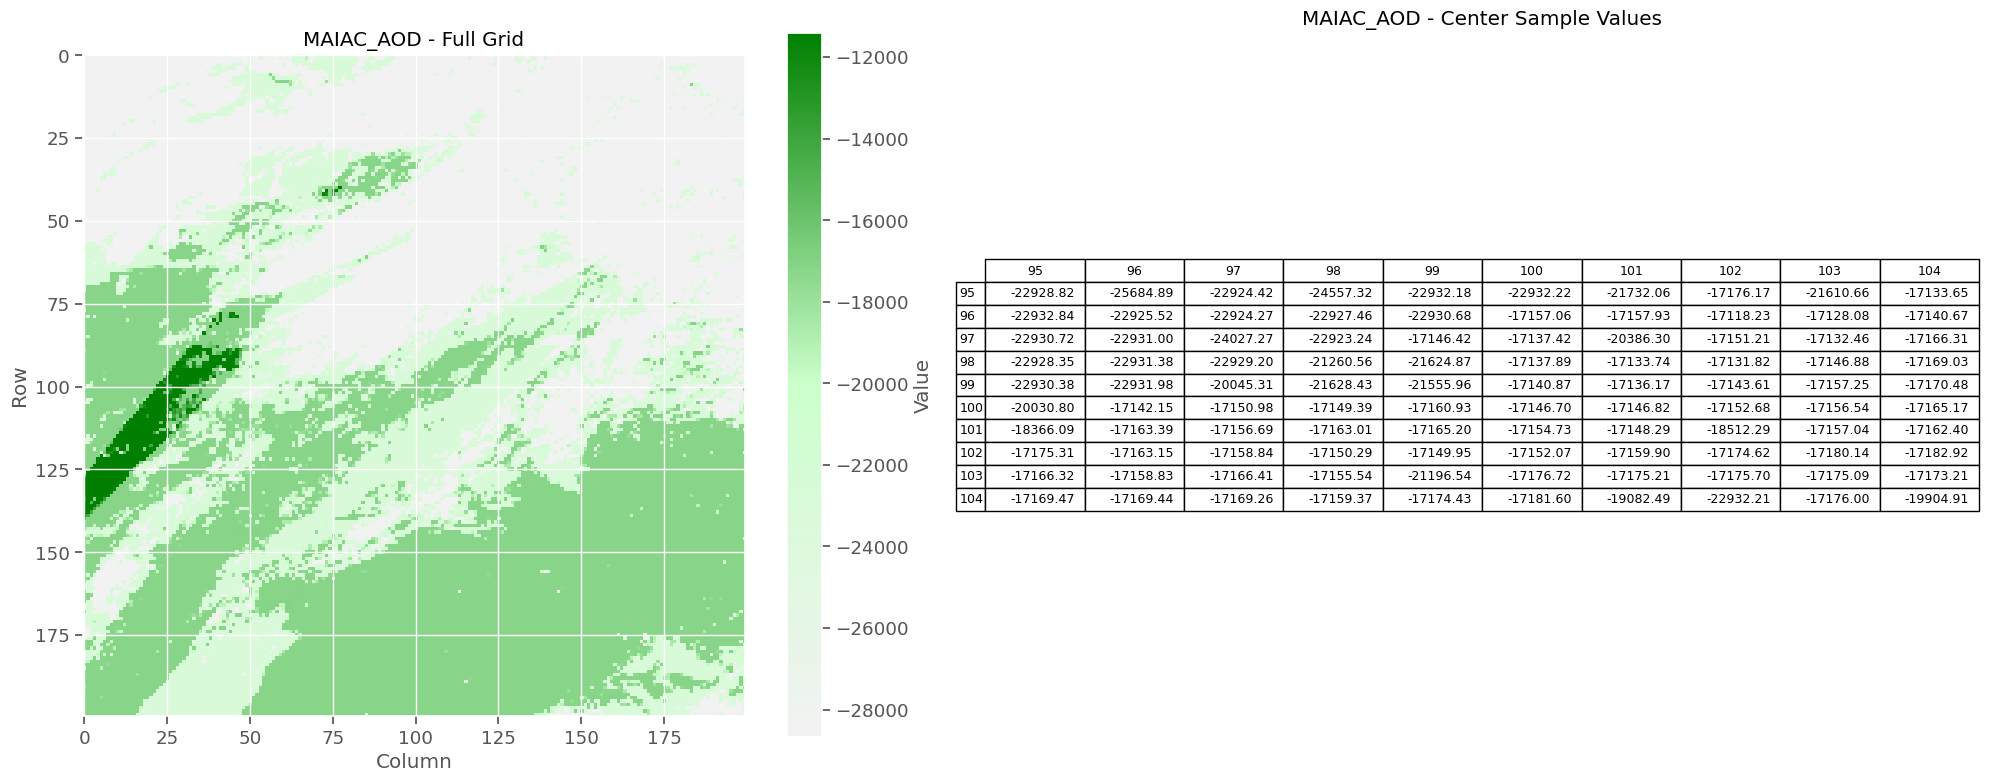


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,-22928.823914,-25684.889695,-22924.420101,-24557.320113,-22932.182379,-22932.222646,-21732.059347,-17176.165481,-21610.655095,-17133.650282
96,-22932.837272,-22925.520022,-22924.271811,-22927.464963,-22930.682412,-17157.055185,-17157.932219,-17118.227701,-17128.084947,-17140.669534
97,-22930.717239,-22930.995278,-24027.266301,-22923.243893,-17146.421222,-17137.422227,-20386.301391,-17151.213227,-17132.464392,-17166.306523
98,-22928.345532,-22931.376334,-22929.200000,-21260.562642,-21624.868220,-17137.889159,-17133.740365,-17131.815202,-17146.878210,-17169.026151
99,-22930.379899,-22931.976975,-20045.309664,-21628.432772,-21555.955486,-17140.867150,-17136.171859,-17143.610272,-17157.247878,-17170.475836
100,-20030.802348,-17142.150754,-17150.981500,-17149.385147,-17160.929679,-17146.702230,-17146.816419,-17152.683382,-17156.543996,-17165.173334
101,-18366.089149,-17163.386106,-17156.685659,-17163.007374,-17165.201904,-17154.727638,-17148.285962,-18512.292695,-17157.040292,-17162.397172
102,-17175.312204,-17163.151774,-17158.835671,-17150.293033,-17149.953370,-17152.074887,-17159.896366,-17174.619343,-17180.141294,-17182.919250
103,-17166.319972,-17158.826555,-17166.412293,-17155.535587,-21196.536481,-17176.715699,-17175.213065,-17175.701508,-17175.090720,-17173.208959


In [5]:
# Get indices for MAIAC AOD channels
maiac_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['maiac_channels']]

# Analyze each MAIAC AOD channel
for i, idx in enumerate(maiac_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name, colormap=cmap_green)
    display(df)

## Analyze TROPOMI Data

Next, let's examine the TROPOMI data (methane, nitrogen dioxide, and carbon monoxide).


### Channel 1: TROPOMI_Methane ###
Min: 1891.5227
Max: 1978.4615
Mean: 1933.5082
Std: 13.9400
Data coverage: 100.00% (40000/40000 non-zero pixels)


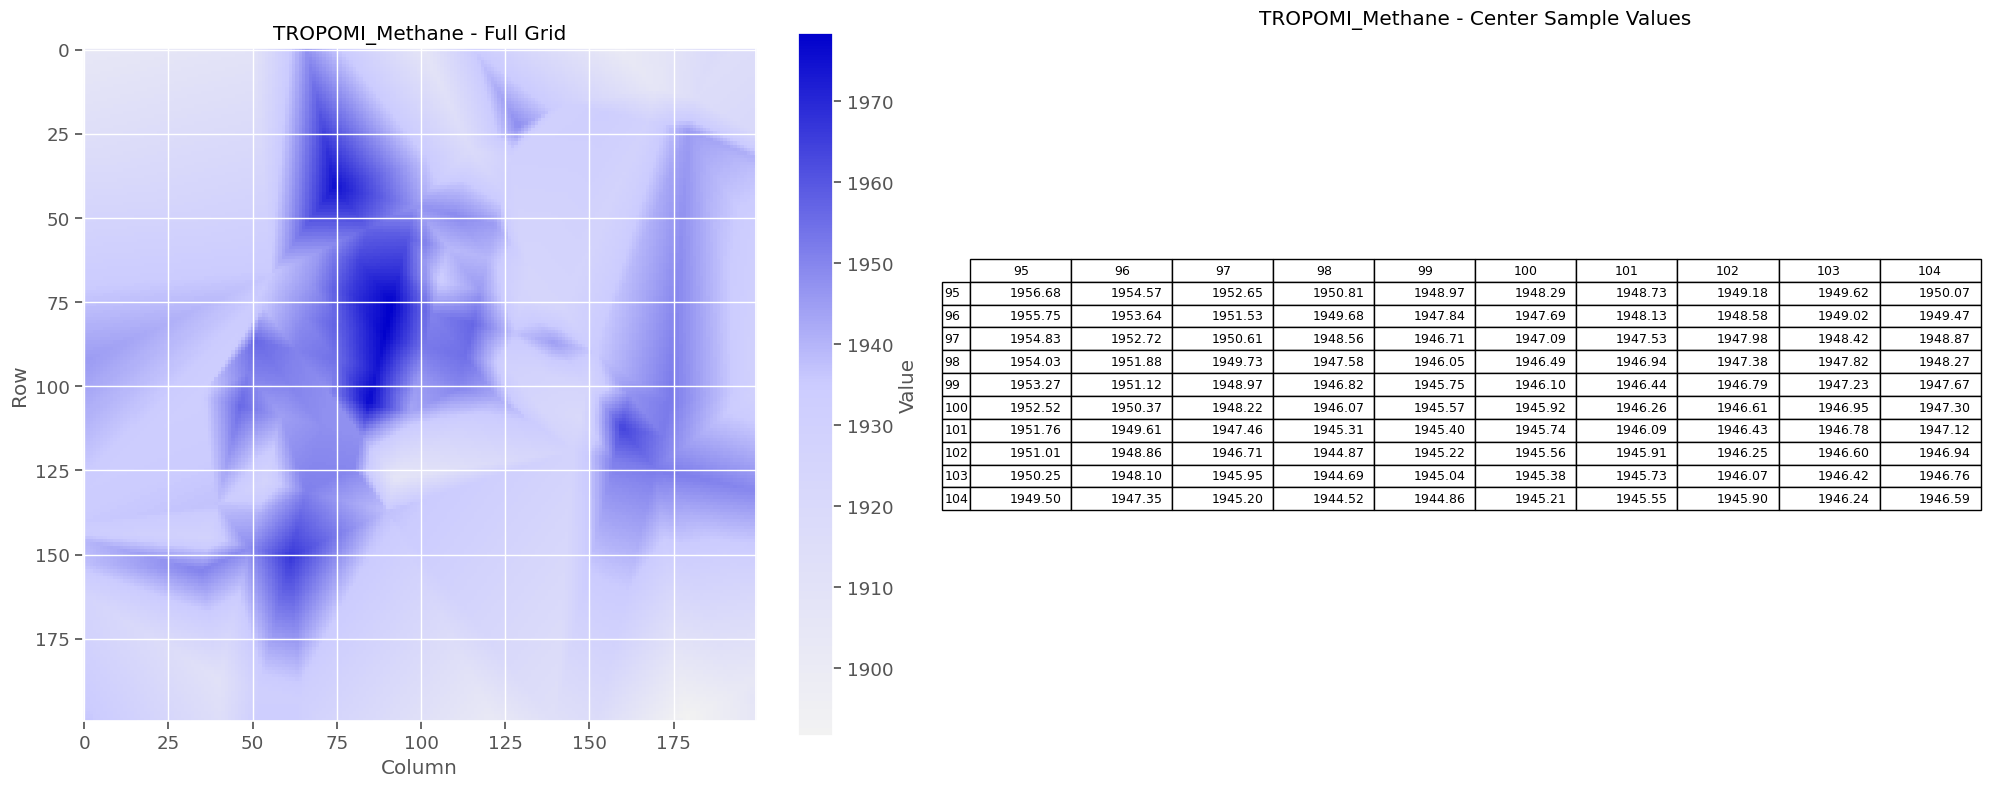


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,1956.675076,1954.565108,1952.652579,1950.811099,1948.969619,1948.288586,1948.733335,1949.178084,1949.622833,1950.067581
96,1955.754671,1953.644702,1951.534734,1949.683127,1947.841647,1947.689158,1948.133907,1948.578656,1949.023405,1949.468153
97,1954.834265,1952.724297,1950.614329,1948.555156,1946.713675,1947.089730,1947.534479,1947.979228,1948.423977,1948.868725
98,1954.027015,1951.877430,1949.727846,1947.583955,1946.045553,1946.490302,1946.935051,1947.379800,1947.824549,1948.269297
99,1953.271905,1951.122321,1948.972737,1946.823152,1945.752206,1946.097111,1946.442016,1946.786921,1947.225121,1947.669869
100,1952.516796,1950.367212,1948.217627,1946.068043,1945.574053,1945.918958,1946.263863,1946.608768,1946.953673,1947.298578
101,1951.761687,1949.612102,1947.462518,1945.312934,1945.395900,1945.740805,1946.085710,1946.430615,1946.775520,1947.120425
102,1951.006577,1948.856993,1946.707409,1944.872842,1945.217747,1945.562652,1945.907557,1946.252462,1946.597367,1946.942272
103,1950.251468,1948.101884,1945.952299,1944.694689,1945.039594,1945.384499,1945.729404,1946.074309,1946.419214,1946.764119



### Channel 2: TROPOMI_NO2 ###
Min: 0.0000
Max: 0.0005
Mean: 0.0001
Std: 0.0001
Data coverage: 100.00% (40000/40000 non-zero pixels)


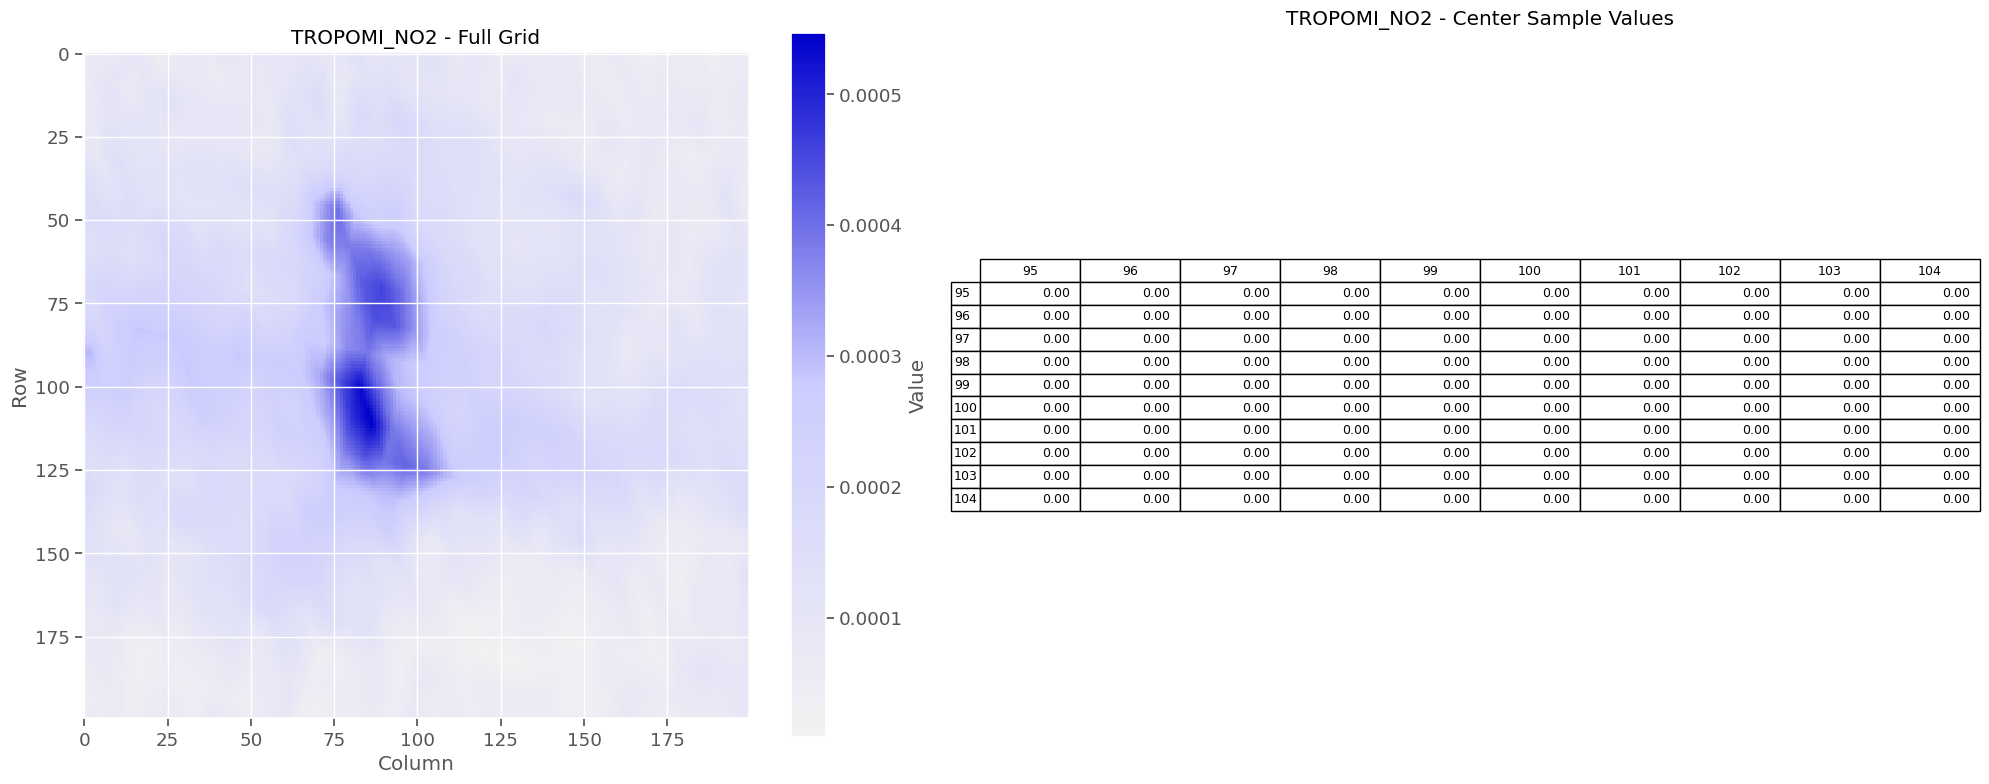


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.000296,0.000290,0.000285,0.000282,0.000279,0.000275,0.000272,0.000269,0.000265,0.000261
96,0.000296,0.000290,0.000286,0.000283,0.000280,0.000276,0.000273,0.000270,0.000265,0.000259
97,0.000297,0.000291,0.000287,0.000284,0.000280,0.000277,0.000274,0.000271,0.000264,0.000257
98,0.000297,0.000292,0.000288,0.000285,0.000281,0.000278,0.000275,0.000271,0.000264,0.000256
99,0.000298,0.000293,0.000289,0.000286,0.000282,0.000279,0.000276,0.000272,0.000264,0.000256
100,0.000298,0.000294,0.000290,0.000287,0.000283,0.000280,0.000276,0.000271,0.000264,0.000256
101,0.000299,0.000295,0.000291,0.000288,0.000284,0.000280,0.000277,0.000271,0.000263,0.000256
102,0.000300,0.000296,0.000292,0.000289,0.000285,0.000281,0.000278,0.000271,0.000263,0.000255
103,0.000302,0.000297,0.000293,0.000290,0.000286,0.000282,0.000279,0.000271,0.000263,0.000255



### Channel 3: TROPOMI_CO ###
Min: 0.0192
Max: 0.0407
Mean: 0.0315
Std: 0.0040
Data coverage: 100.00% (40000/40000 non-zero pixels)


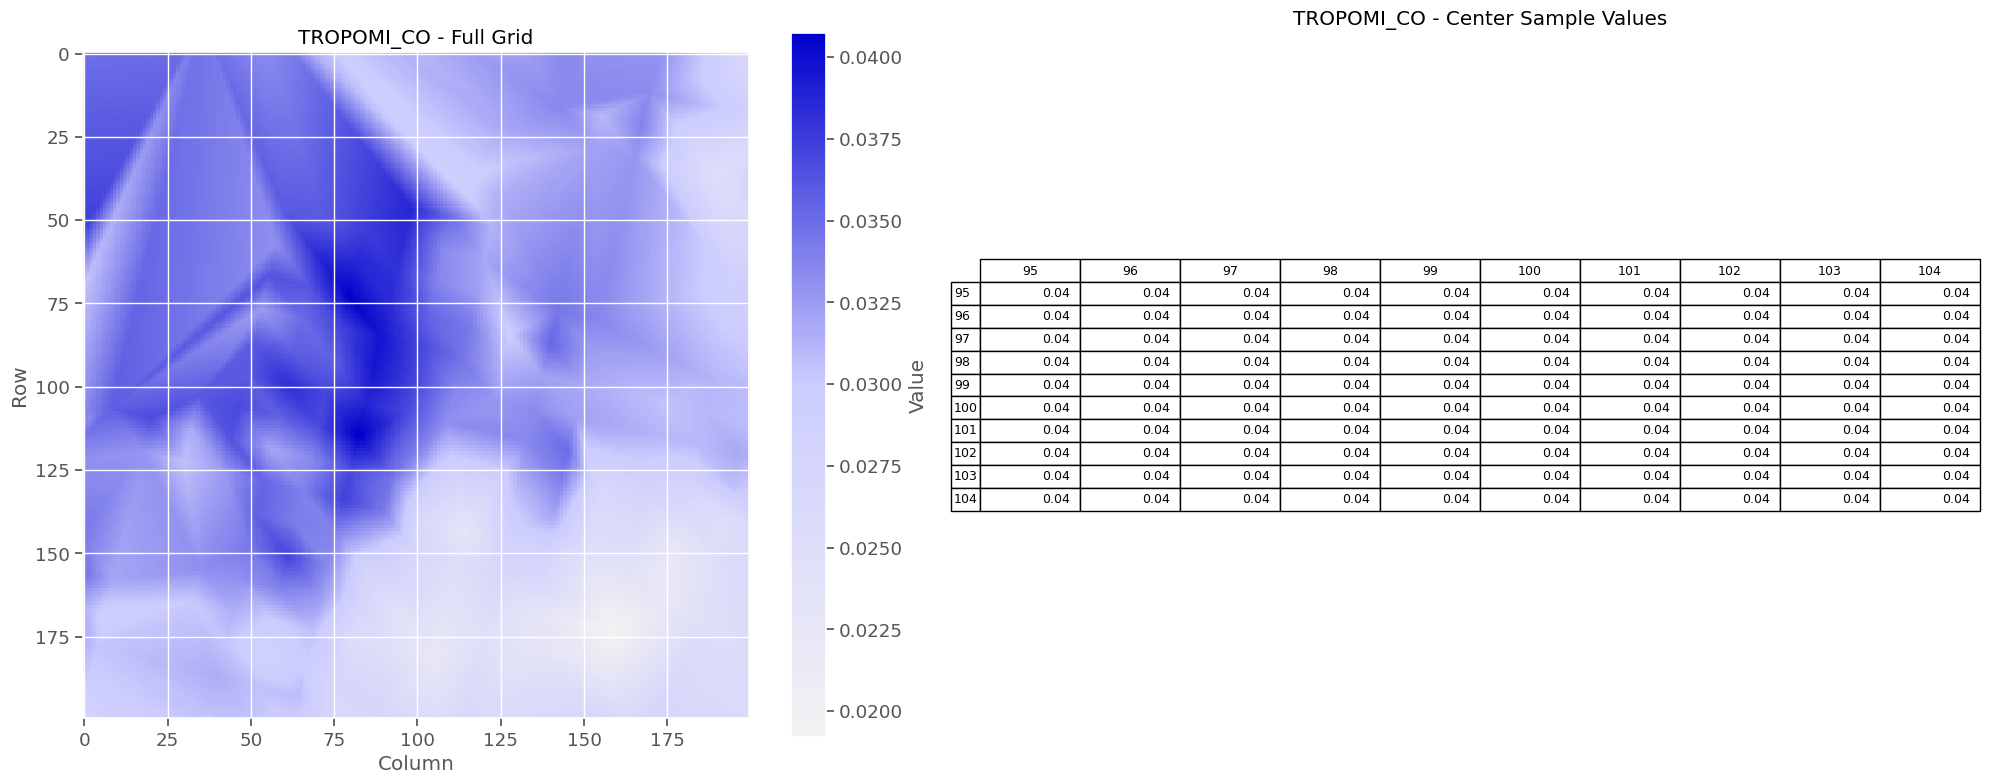


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.038062,0.037877,0.037665,0.037444,0.037222,0.036972,0.036693,0.036415,0.036136,0.035858
96,0.038009,0.037824,0.037638,0.037418,0.037197,0.036933,0.036655,0.036376,0.036098,0.035820
97,0.037955,0.037770,0.037585,0.037393,0.037171,0.036895,0.036616,0.036338,0.036059,0.035781
98,0.037887,0.037707,0.037527,0.037346,0.037134,0.036856,0.036578,0.036299,0.036021,0.035742
99,0.037812,0.037632,0.037452,0.037272,0.037047,0.036779,0.036519,0.036259,0.035982,0.035704
100,0.037737,0.037557,0.037377,0.037197,0.036948,0.036665,0.036402,0.036142,0.035883,0.035623
101,0.037661,0.037481,0.037301,0.037121,0.036849,0.036566,0.036285,0.036025,0.035766,0.035506
102,0.037586,0.037406,0.037226,0.037033,0.036750,0.036467,0.036184,0.035908,0.035649,0.035389
103,0.037511,0.037331,0.037151,0.036934,0.036651,0.036368,0.036085,0.035802,0.035532,0.035272


In [6]:
# Get indices for TROPOMI channels
tropomi_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                  if name in channel_info['tropomi_channels']]

# Analyze each TROPOMI channel
for i, idx in enumerate(tropomi_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name)
    display(df)

## Analyze MODIS Fire Data

Now, let's examine the MODIS Fire Radiative Power (FRP) data.


### Channel 4: MODIS_FRP ###
Min: 0.0000
Max: 0.5421
Mean: 0.1710
Std: 0.1862
Data coverage: 78.08% (31230/40000 non-zero pixels)


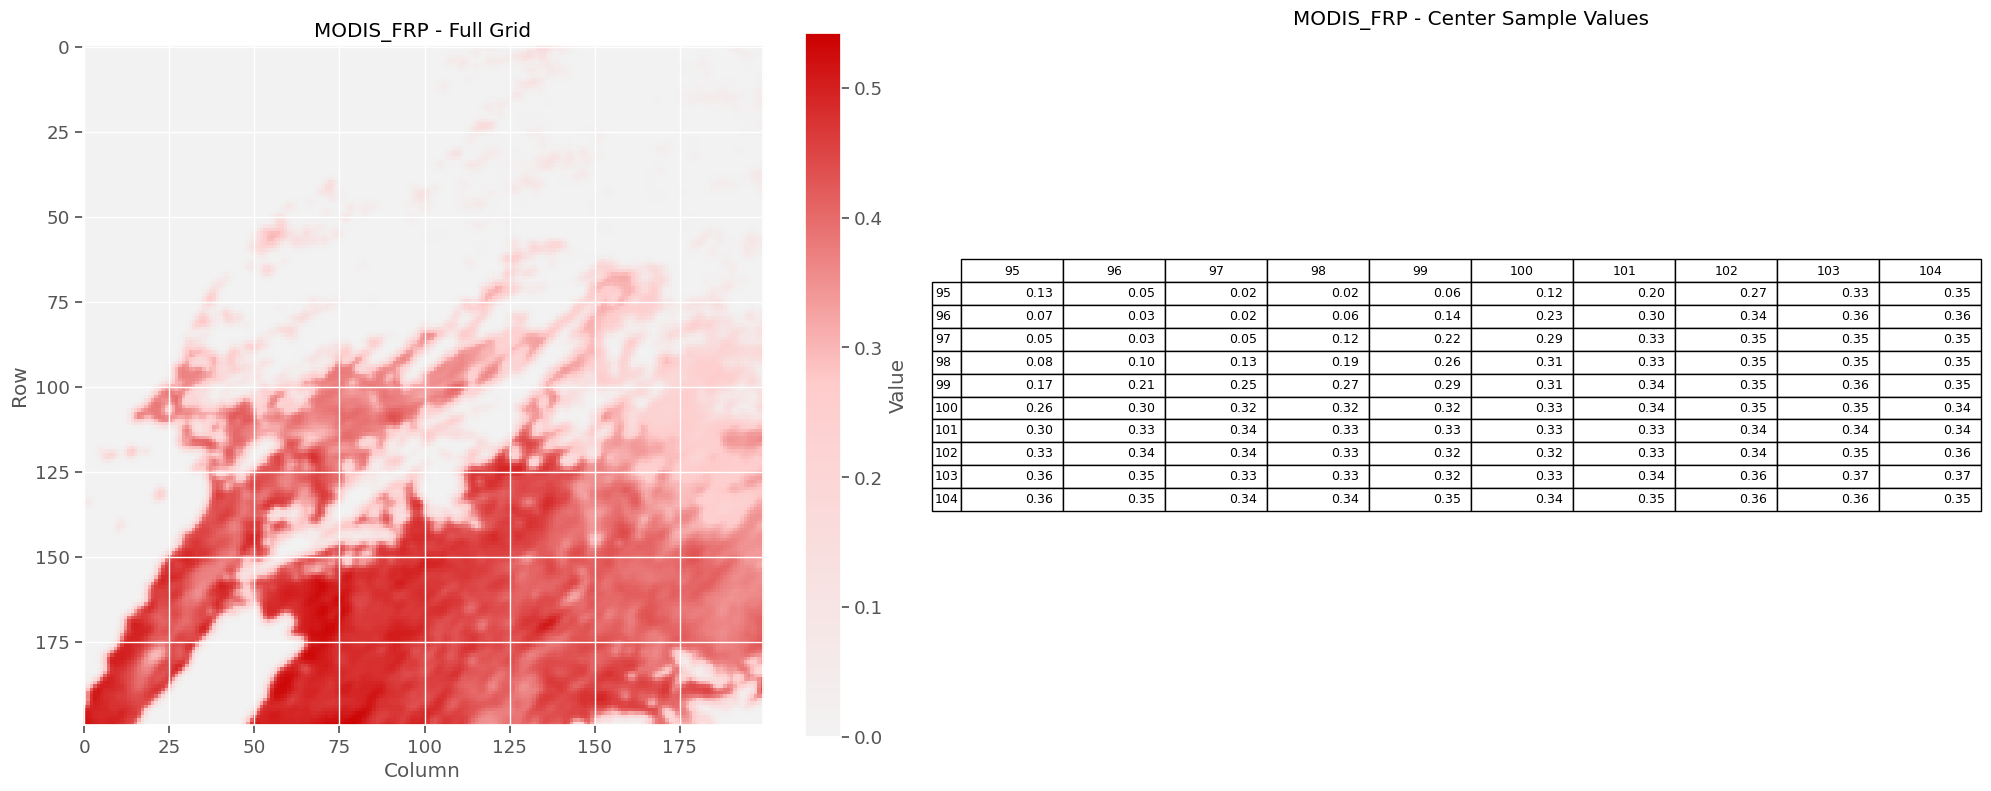


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.127271,0.054223,0.016315,0.019134,0.056278,0.120730,0.197687,0.270798,0.325254,0.351777
96,0.071525,0.025189,0.017336,0.055557,0.138722,0.230830,0.298795,0.339164,0.355364,0.356124
97,0.050511,0.031996,0.049827,0.118034,0.217725,0.294512,0.334489,0.350334,0.352398,0.350134
98,0.079435,0.097823,0.133412,0.194501,0.261350,0.305512,0.333749,0.348160,0.351456,0.351641
99,0.167239,0.212167,0.245129,0.267243,0.290410,0.313788,0.337314,0.351642,0.355138,0.352052
100,0.259533,0.298891,0.315813,0.317027,0.321094,0.329644,0.340432,0.347974,0.348449,0.342320
101,0.301146,0.328214,0.335241,0.334710,0.334384,0.333258,0.334146,0.338217,0.341933,0.341971
102,0.333913,0.340790,0.335984,0.329964,0.324397,0.323429,0.330912,0.343564,0.354918,0.358762
103,0.355043,0.346577,0.334926,0.325864,0.320727,0.326905,0.343718,0.361849,0.369479,0.366595


In [7]:
# Get indices for MODIS Fire channels
modis_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['modis_fire_channels']]

# Analyze each MODIS Fire channel
for i, idx in enumerate(modis_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name, colormap=cmap_red)
    display(df)

## Analyze MERRA-2 Data

Next, let's examine the MERRA-2 data (PBL Height, Surface Air Temperature, and Surface Exchange Coefficient).


### Channel 5: MERRA2_PBL_Height ###
Min: 64.8523
Max: 1344.4617
Mean: 437.8813
Std: 314.9763
Data coverage: 100.00% (40000/40000 non-zero pixels)


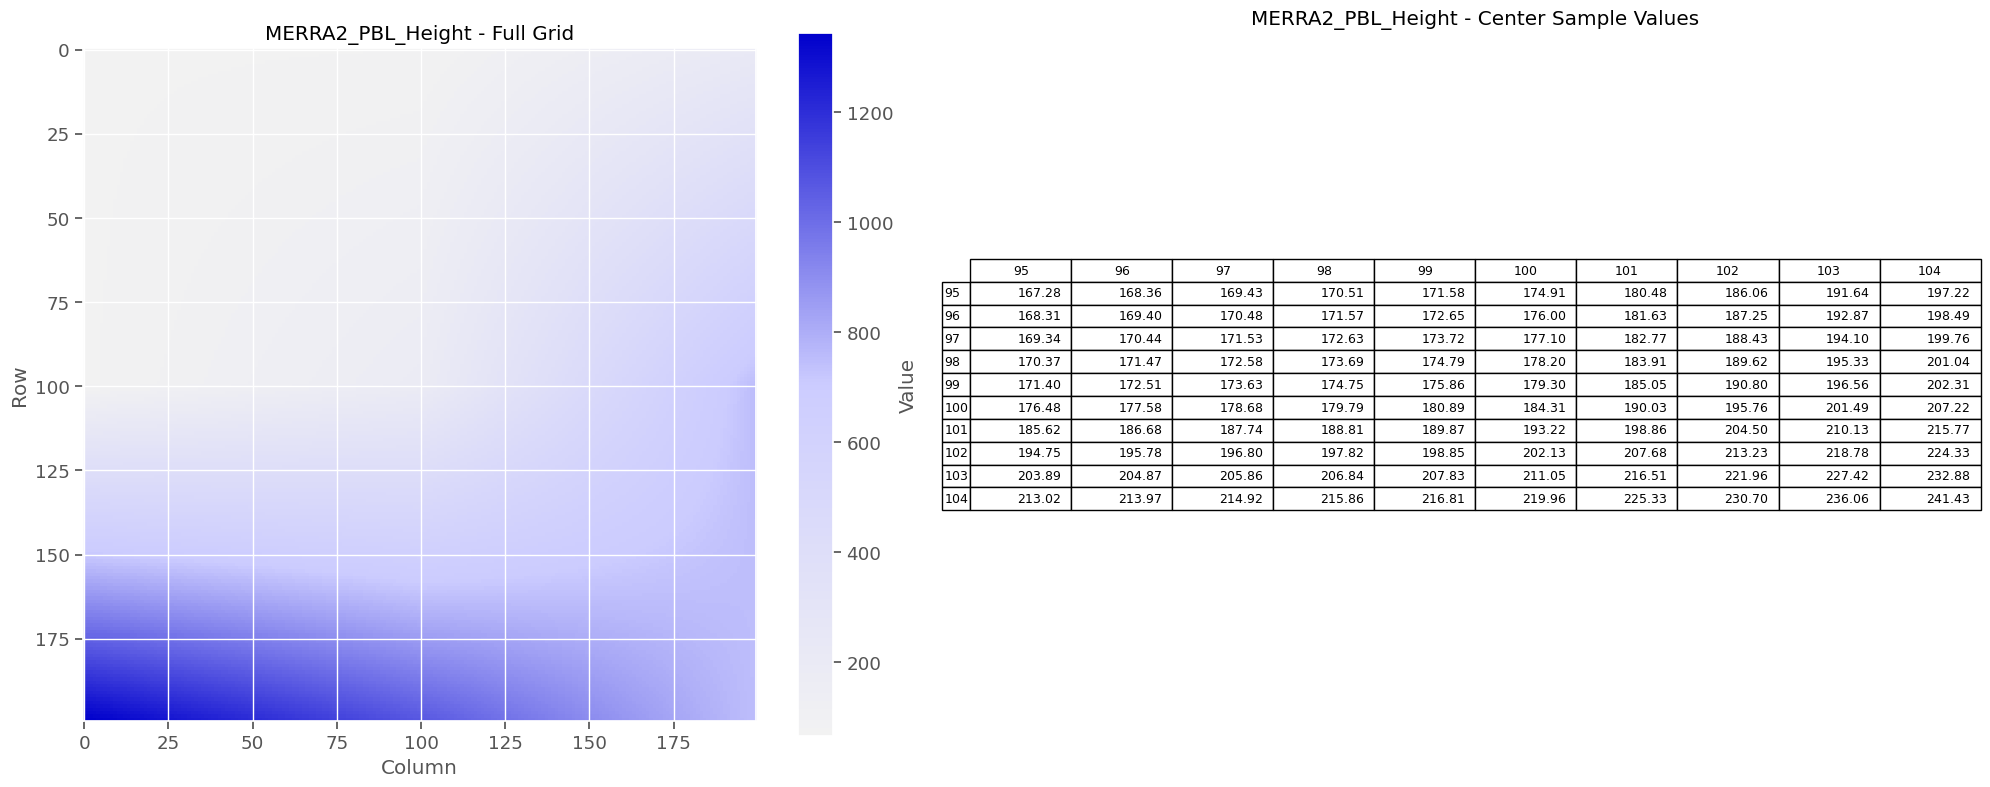


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,167.283890,168.357727,169.431549,170.505386,171.579208,174.905548,180.484360,186.063187,191.642014,197.220840
96,168.312180,169.396790,170.481400,171.566010,172.650620,176.003998,181.626175,187.248337,192.870514,198.492676
97,169.340469,170.435852,171.531250,172.626633,173.722015,177.102463,182.767975,188.433487,194.098999,199.764511
98,170.368759,171.474930,172.581085,173.687256,174.793411,178.200928,183.909775,189.618637,195.327484,201.036346
99,171.397049,172.513992,173.630936,174.747879,175.864822,179.299393,185.051590,190.803787,196.555984,202.308182
100,176.479202,177.581955,178.684708,179.787460,180.890213,184.305893,190.034515,195.763123,201.491745,207.220367
101,185.615219,186.678802,187.742401,188.806000,189.869583,193.220444,198.858551,204.496674,210.134781,215.772903
102,194.751221,195.775650,196.800095,197.824524,198.848969,202.134995,207.682602,213.230209,218.777832,224.325439
103,203.887222,204.872513,205.857788,206.843063,207.828339,211.049530,216.506653,221.963760,227.420868,232.877975



### Channel 6: MERRA2_Surface_Air_Temp ###
Min: 290.2972
Max: 294.4489
Mean: 293.1555
Std: 0.8067
Data coverage: 100.00% (40000/40000 non-zero pixels)


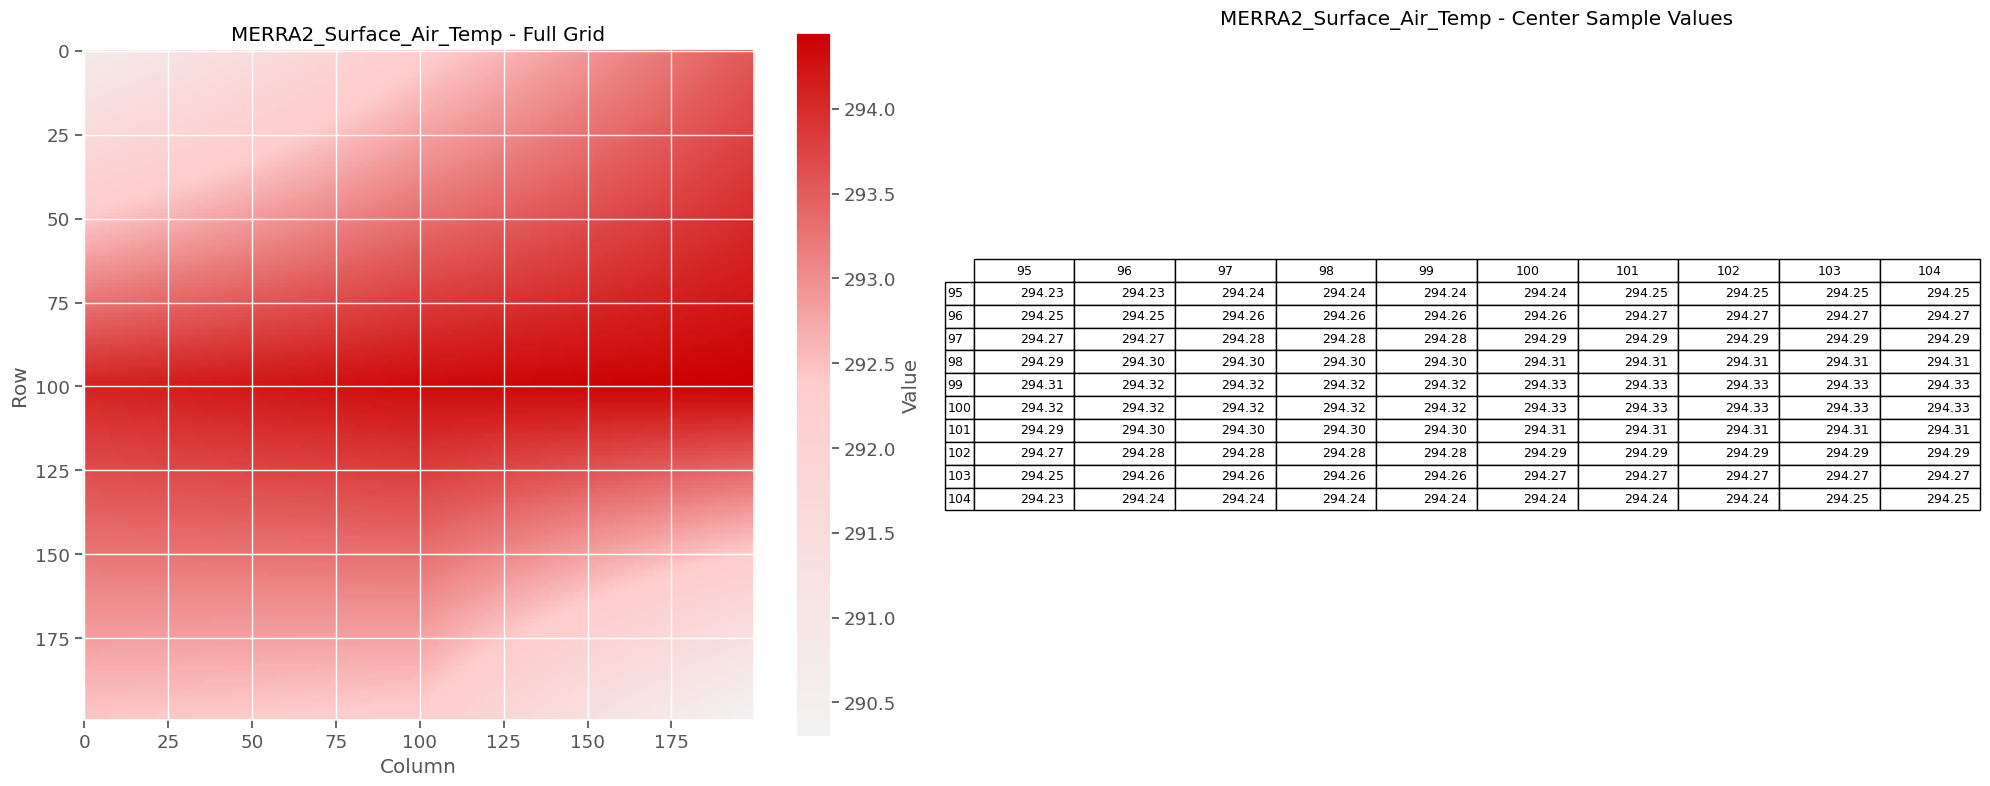


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,294.229370,294.232391,294.235413,294.238434,294.241486,294.243835,294.245544,294.247253,294.248962,294.250671
96,294.250671,294.253571,294.256470,294.259369,294.262268,294.264526,294.266113,294.267700,294.269287,294.270874
97,294.272003,294.274780,294.277527,294.280304,294.283081,294.285187,294.286652,294.288116,294.289581,294.291077
98,294.293335,294.295959,294.298584,294.301239,294.303864,294.305847,294.307220,294.308563,294.309906,294.311279
99,294.314667,294.317169,294.319672,294.322144,294.324646,294.326538,294.327759,294.329010,294.330231,294.331482
100,294.315186,294.317596,294.320038,294.322449,294.324860,294.326599,294.327667,294.328735,294.329803,294.330872
101,294.294952,294.297333,294.299713,294.302094,294.304474,294.306091,294.306946,294.307800,294.308655,294.309509
102,294.274689,294.277039,294.279388,294.281738,294.284058,294.285553,294.286194,294.286835,294.287476,294.288116
103,294.254456,294.256744,294.259064,294.261353,294.263672,294.265045,294.265472,294.265900,294.266327,294.266754



### Channel 7: MERRA2_Surface_Exchange_Coef ###
Min: 0.0006
Max: 0.0041
Mean: 0.0017
Std: 0.0006
Data coverage: 100.00% (40000/40000 non-zero pixels)


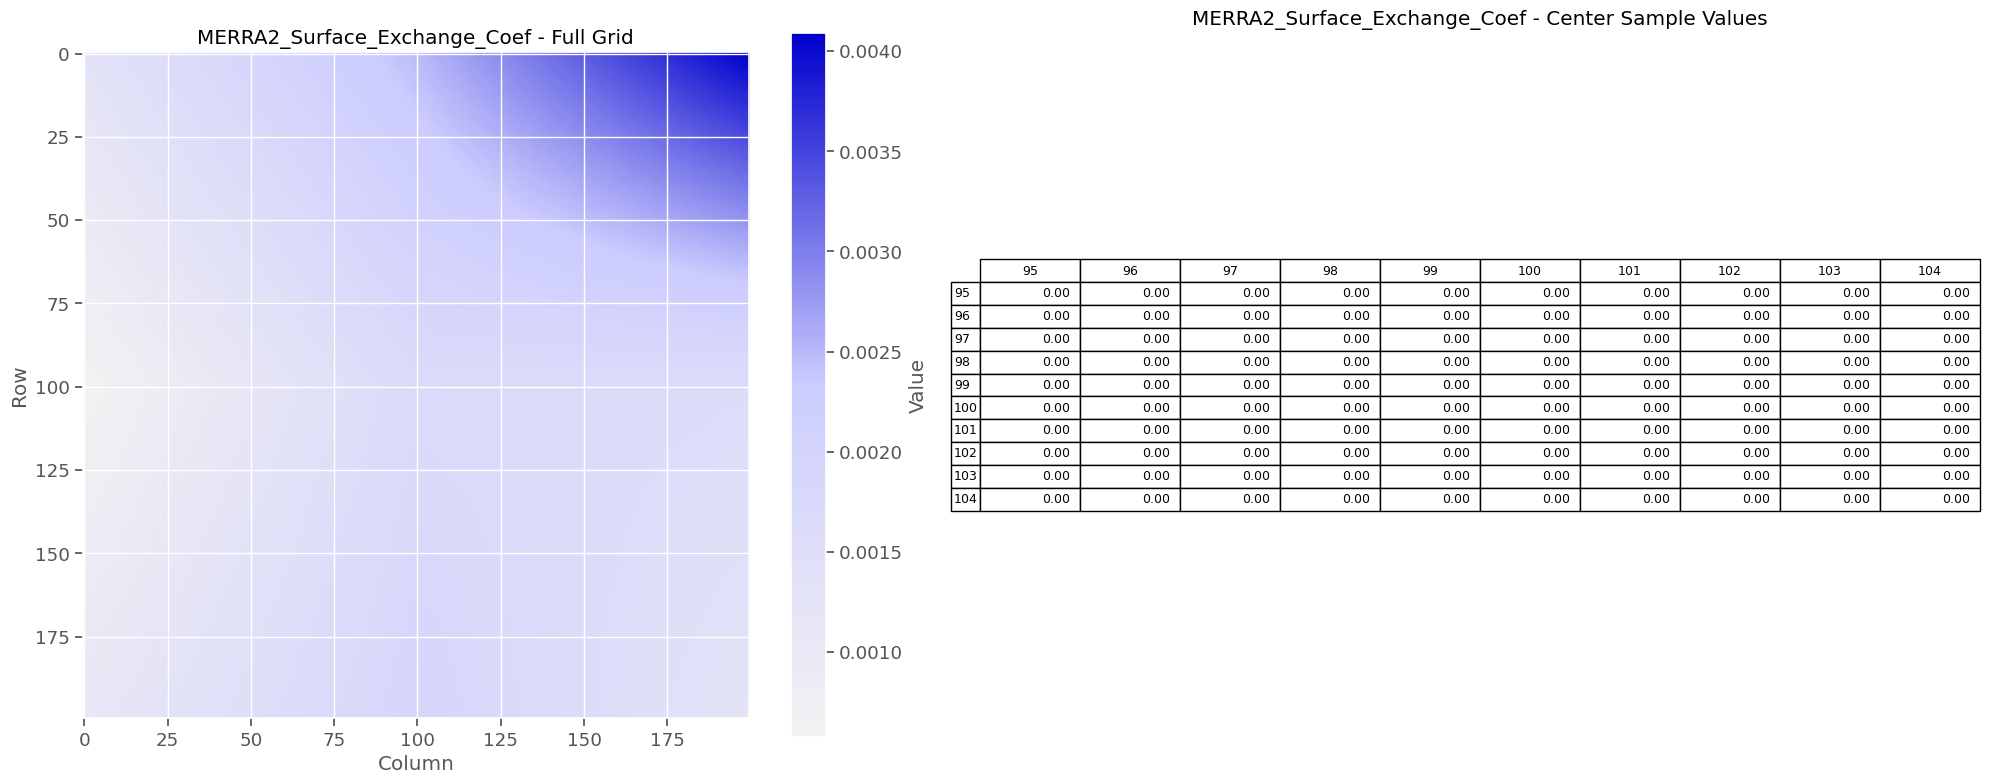


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.001637,0.001647,0.001658,0.001669,0.001680,0.001685,0.001685,0.001685,0.001685,0.001685
96,0.001628,0.001639,0.001650,0.001661,0.001672,0.001677,0.001677,0.001676,0.001676,0.001676
97,0.001620,0.001631,0.001641,0.001652,0.001663,0.001668,0.001668,0.001667,0.001667,0.001667
98,0.001611,0.001622,0.001633,0.001644,0.001655,0.001660,0.001659,0.001659,0.001658,0.001657
99,0.001603,0.001614,0.001625,0.001635,0.001646,0.001651,0.001650,0.001650,0.001649,0.001648
100,0.001600,0.001611,0.001622,0.001632,0.001643,0.001648,0.001647,0.001646,0.001645,0.001645
101,0.001602,0.001613,0.001624,0.001635,0.001645,0.001650,0.001649,0.001649,0.001648,0.001647
102,0.001605,0.001616,0.001626,0.001637,0.001648,0.001653,0.001652,0.001651,0.001650,0.001649
103,0.001607,0.001618,0.001629,0.001639,0.001650,0.001655,0.001654,0.001653,0.001652,0.001651


In [8]:
# Get indices for MERRA-2 channels
merra2_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                 if name in channel_info['merra2_channels']]

# Analyze each MERRA-2 channel
for i, idx in enumerate(merra2_indices):
    channel_name = channel_info['channel_names'][idx]
    
    # Use red colormap for temperature
    if 'Temp' in channel_name:
        cmap = cmap_red
    else:
        cmap = cmap_blue
        
    df = analyze_channel(data, idx, channel_name, colormap=cmap)
    display(df)

## Analyze METAR Meteorological Data

Finally, let's examine the METAR meteorological data.


### Channel 8: METAR_Wind_Speed ###
Min: 4.6031
Max: 11.5078
Mean: 7.0964
Std: 1.2533
Data coverage: 100.00% (40000/40000 non-zero pixels)


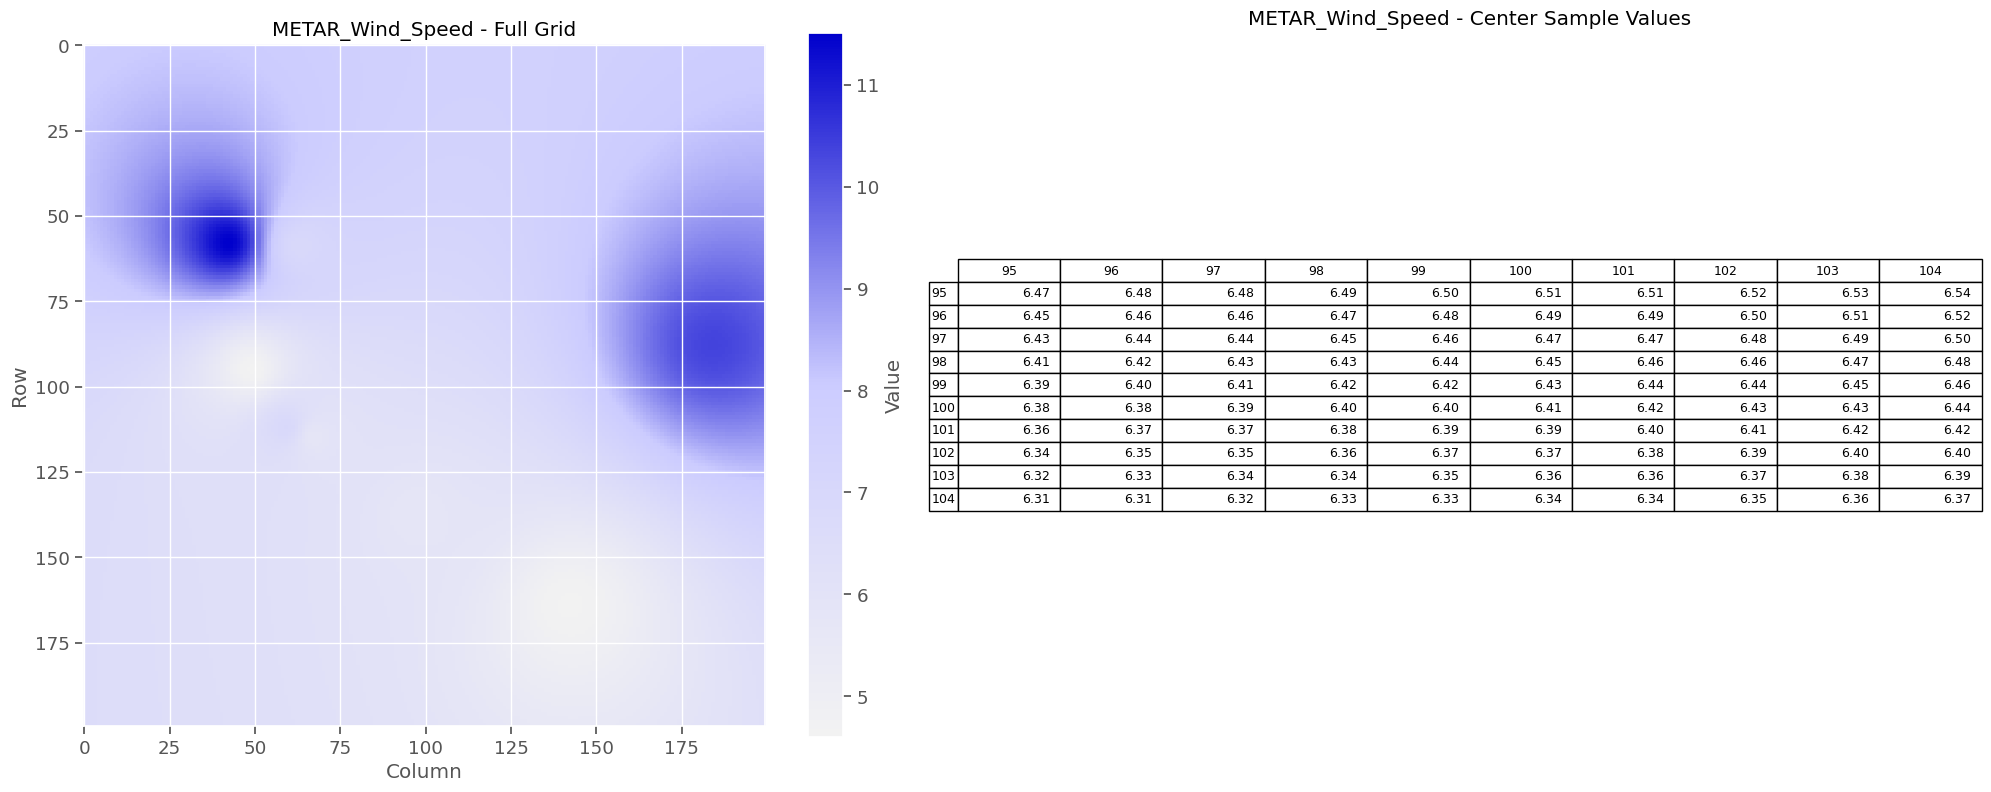


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,6.468594,6.475826,6.483086,6.490412,6.497844,6.505421,6.513183,6.521173,6.529429,6.537993
96,6.449355,6.456614,6.463893,6.471231,6.478667,6.486243,6.493998,6.501975,6.510214,6.518756
97,6.430472,6.437717,6.444976,6.452288,6.459694,6.467234,6.474950,6.482883,6.491076,6.499569
98,6.411937,6.419128,6.426329,6.433578,6.440916,6.448387,6.456032,6.463892,6.472011,6.480428
99,6.393740,6.400838,6.407940,6.415089,6.422326,6.429694,6.437235,6.444993,6.453009,6.461325
100,6.375867,6.382831,6.389797,6.396809,6.403908,6.411140,6.418547,6.426172,6.434059,6.442250
101,6.358300,6.365090,6.371881,6.378719,6.385646,6.392709,6.399951,6.407417,6.415149,6.423189
102,6.341014,6.347591,6.354170,6.360797,6.367518,6.374380,6.381429,6.388708,6.396260,6.404129
103,6.323985,6.330308,6.336637,6.343018,6.349500,6.356131,6.362957,6.370024,6.377374,6.385050



### Channel 9: METAR_Wind_Direction ###
Min: 150.0000
Max: 350.0000
Mean: 247.3742
Std: 19.5916
Data coverage: 100.00% (40000/40000 non-zero pixels)


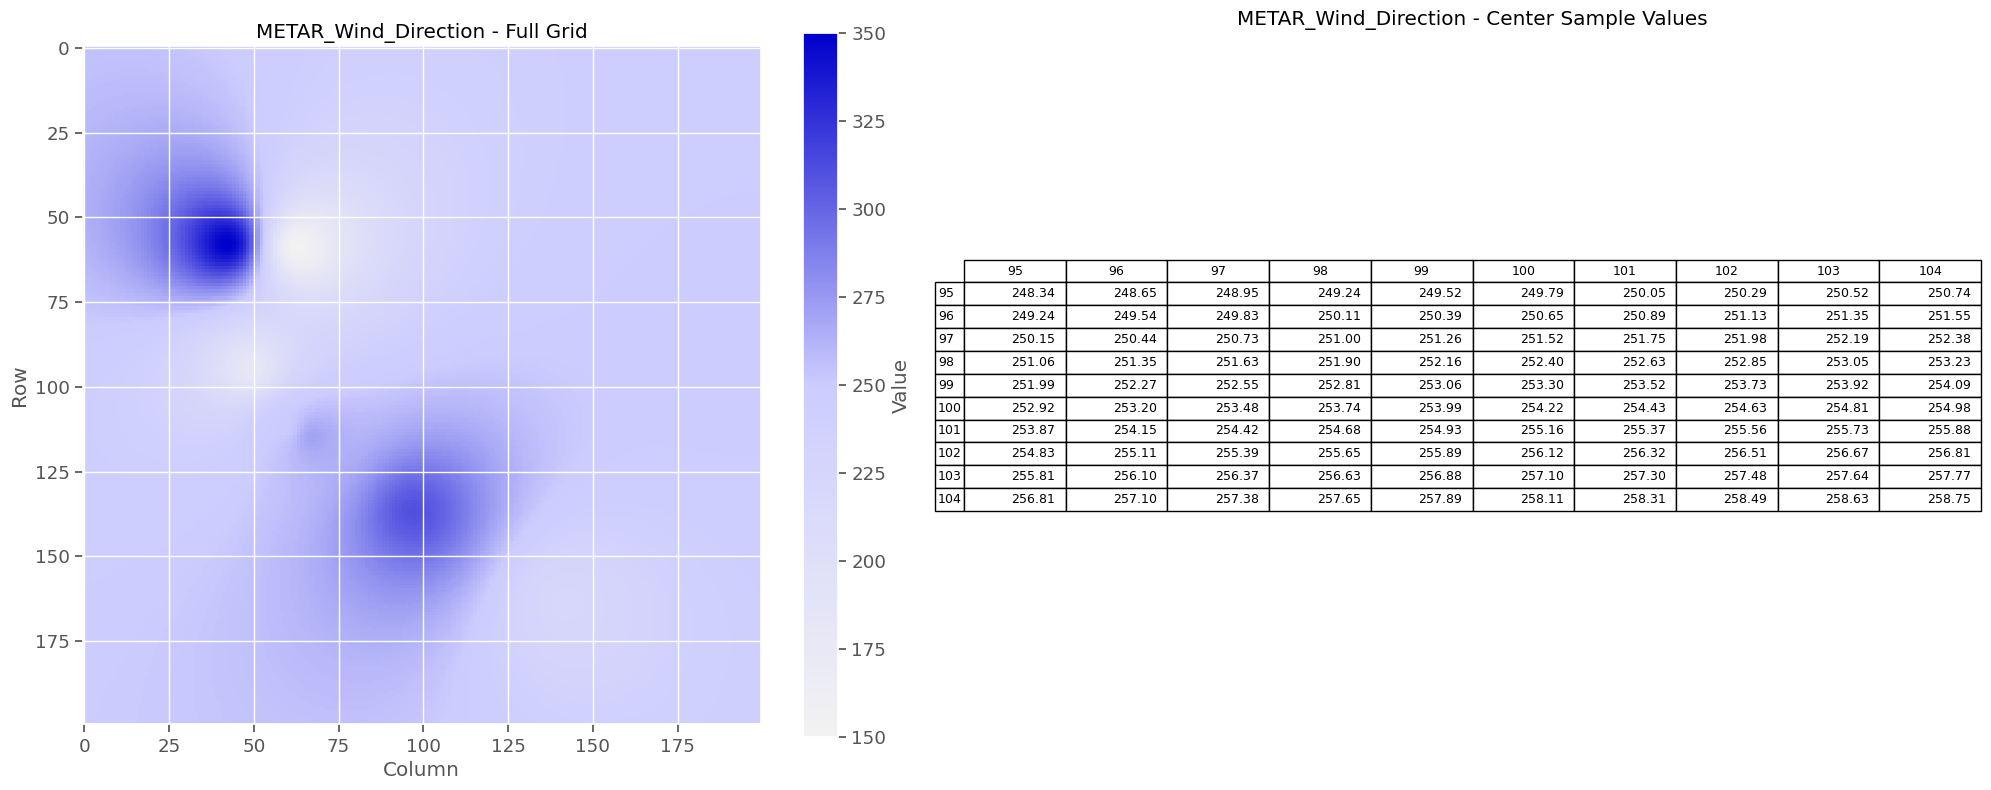


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,248.341907,248.649005,248.948459,249.239118,249.519862,249.789626,250.047419,250.292343,250.523598,250.740497
96,249.242817,249.541473,249.832434,250.114403,250.386130,250.646438,250.894242,251.128566,251.348555,251.553480
97,250.150120,250.441865,250.725766,251.000360,251.264254,251.516149,251.754861,251.979335,252.188657,252.382061
98,251.064991,251.351448,251.629792,251.898378,252.155657,252.400200,252.630717,252.846073,253.045298,253.227591
99,251.988801,252.271689,252.546057,252.810057,253.061973,253.300235,253.523446,253.730392,253.920048,254.091584
100,252.923146,253.204295,253.476345,253.737234,253.985063,254.218120,254.434897,254.634101,254.814661,254.975727
101,253.869886,254.151235,254.422704,254.682002,254.927041,255.155961,255.367144,255.559223,255.731089,255.881881
102,254.831184,255.114778,255.387475,255.646742,255.890294,256.116122,256.322501,256.508001,256.671482,256.812091
103,255.809540,256.097529,256.373327,256.634146,256.877504,257.101243,257.303539,257.482909,257.638200,257.768583



### Channel 10: METAR_Precipitation ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


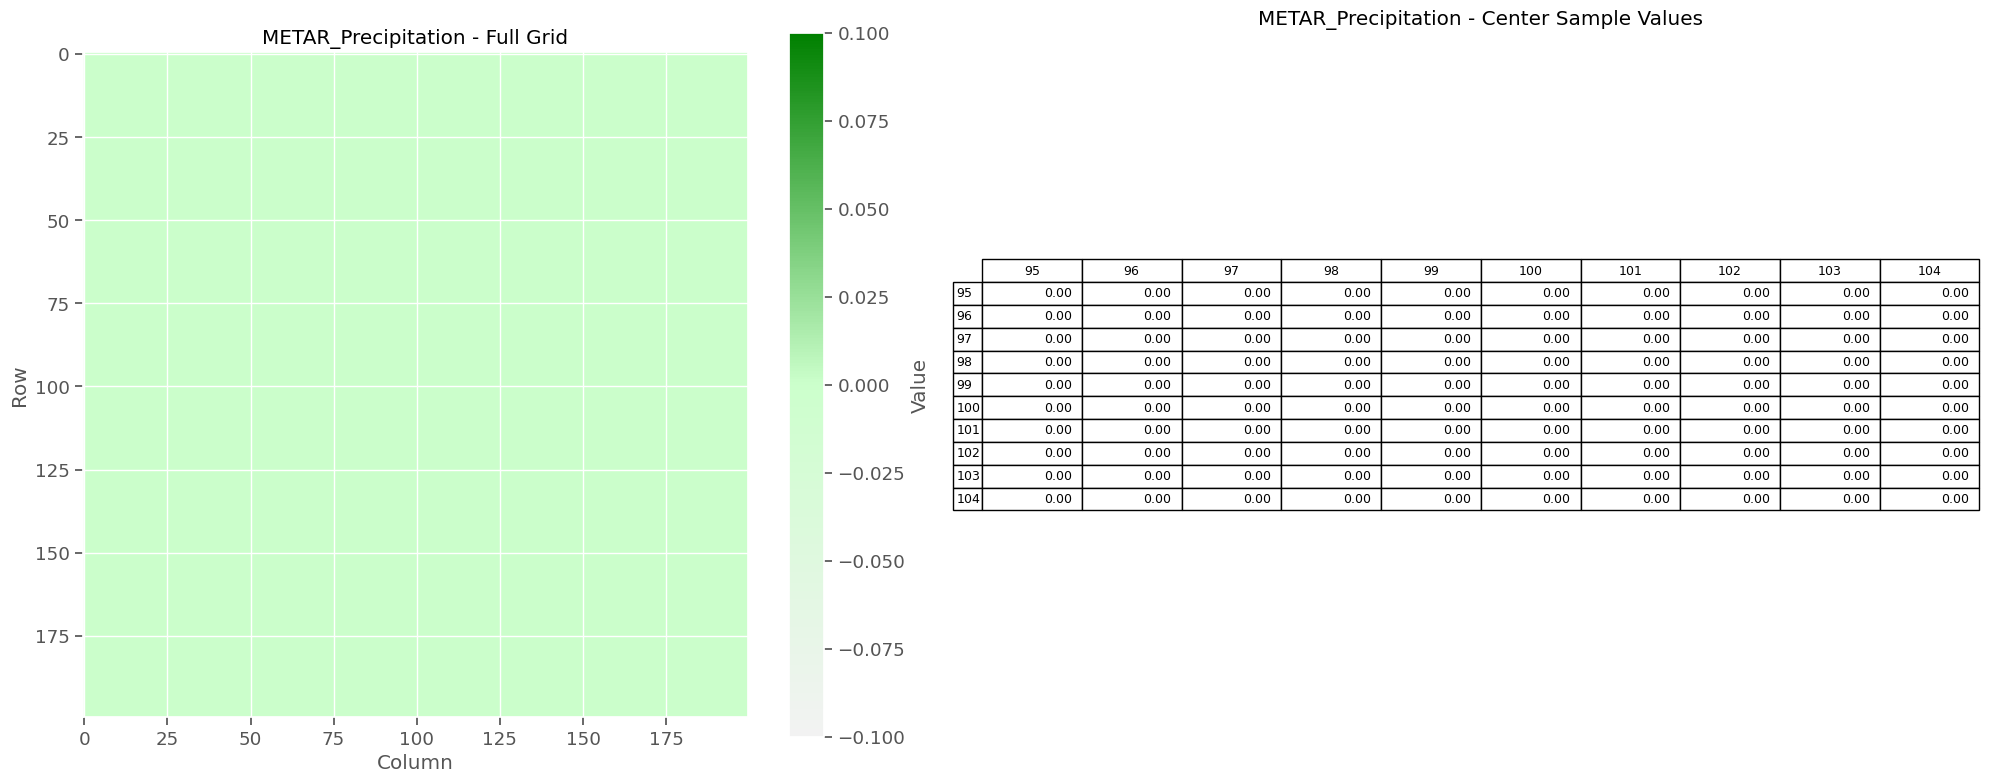


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 11: METAR_Humidity ###
Min: 11.0700
Max: 35.7400
Mean: 23.7160
Std: 3.8414
Data coverage: 100.00% (40000/40000 non-zero pixels)


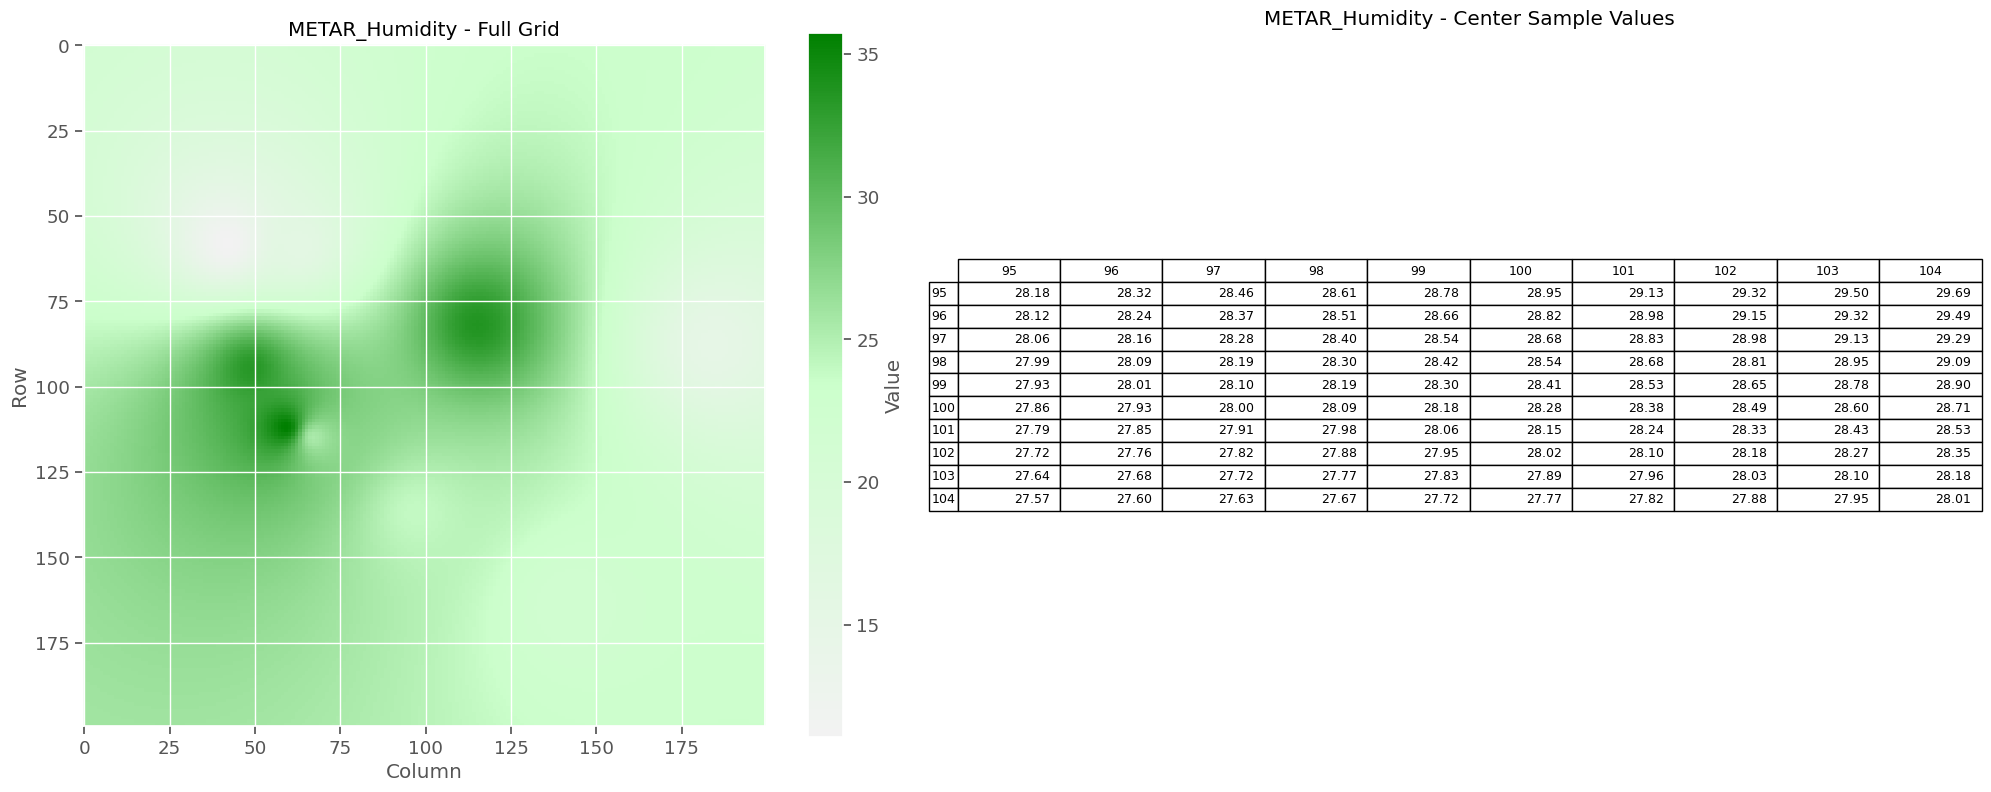


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,28.183151,28.315511,28.459536,28.614389,28.778989,28.951989,29.131766,29.316422,29.503793,29.691476
96,28.122864,28.241207,28.370612,28.510290,28.659225,28.816163,28.979601,29.147784,29.318722,29.490209
97,28.059916,28.164724,28.279994,28.404984,28.538747,28.680119,28.827712,28.979913,29.134895,29.290640
98,27.994744,28.086560,28.188250,28.299121,28.418292,28.544689,28.677034,28.813849,28.953465,29.094041
99,27.927678,28.007093,28.095812,28.193190,28.298416,28.410500,28.528272,28.650382,28.775307,28.901375
100,27.858952,27.926586,28.002976,28.087531,28.179505,28.277992,28.381922,28.490066,28.601042,28.713330
101,27.788705,27.845193,27.909921,27.982347,28.061792,28.147429,28.238286,28.333246,28.431056,28.530339
102,27.716991,27.762974,27.816712,27.877716,27.945369,28.018923,28.097497,28.180078,28.265533,28.352616
103,27.643790,27.679900,27.723316,27.773604,27.830207,27.892452,27.959541,28.030560,28.104485,28.180189



### Channel 12: METAR_Heat_Index ###
Min: 60.8000
Max: 75.0000
Mean: 69.8521
Std: 1.8187
Data coverage: 100.00% (40000/40000 non-zero pixels)


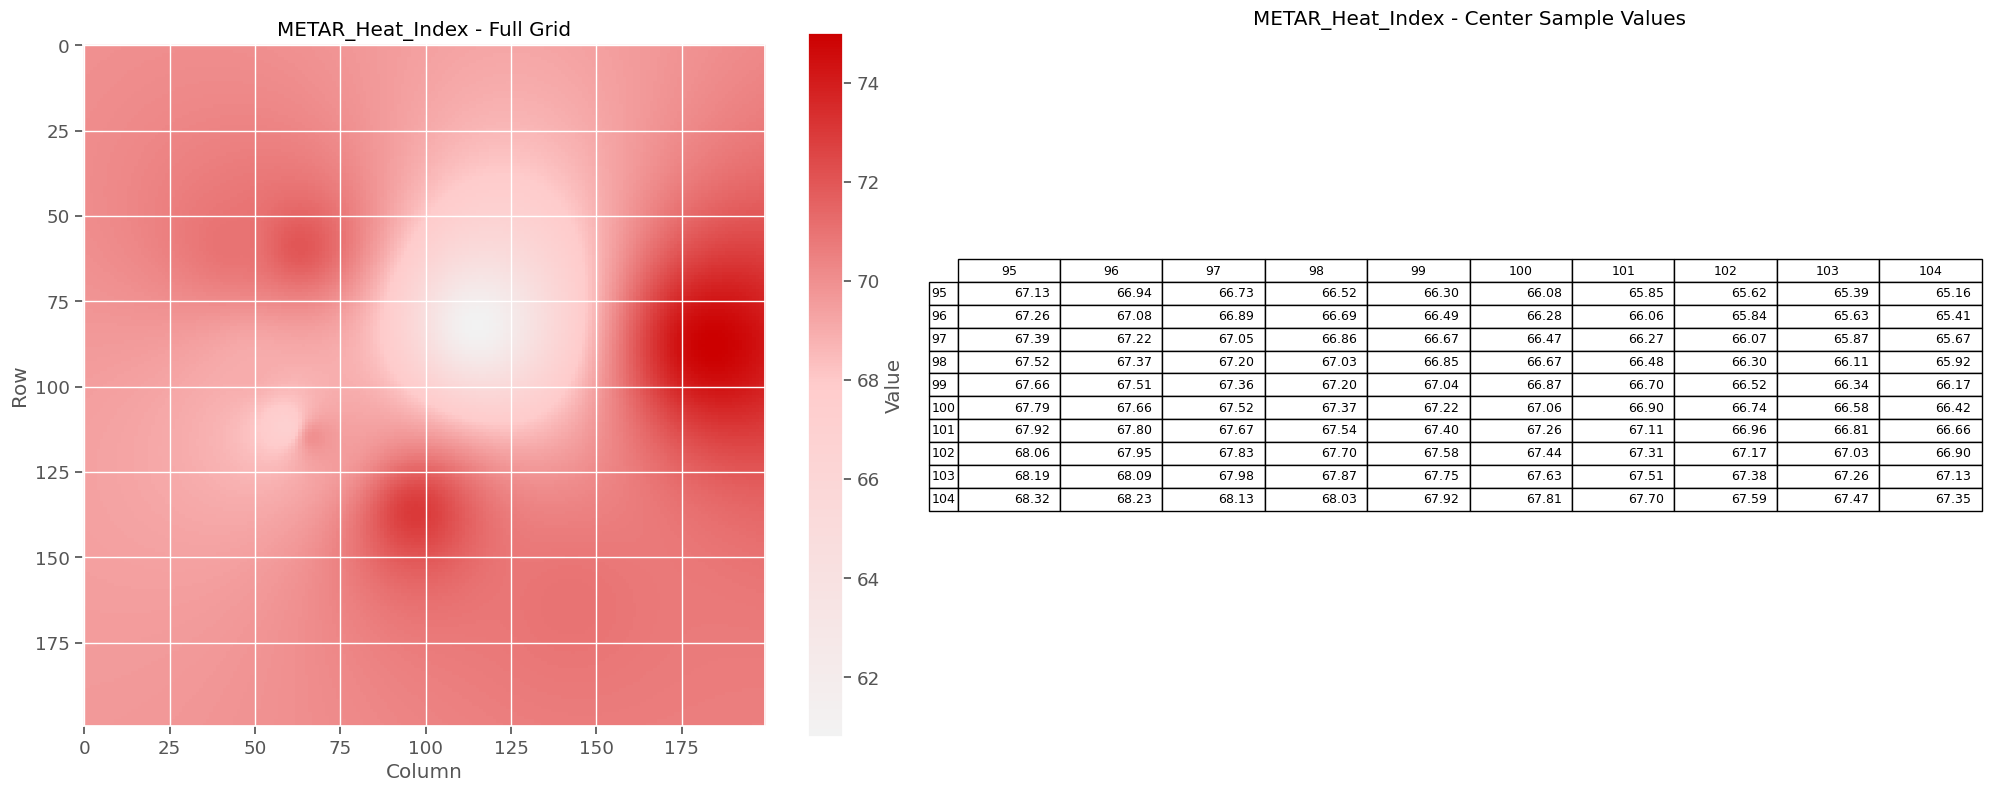


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,67.127922,66.935561,66.733463,66.522523,66.303898,66.079033,65.849661,65.617800,65.385739,65.156001
96,67.258424,67.078159,66.888790,66.691159,66.486350,66.275707,66.060834,65.843596,65.626100,65.410662
97,67.390723,67.222469,67.045722,66.861270,66.670124,66.473527,66.272959,66.070134,65.866981,65.665622
98,67.524079,67.367673,67.203355,67.031860,66.854123,66.671289,66.484718,66.295976,66.106827,65.919202
99,67.657870,67.513085,67.360935,67.202099,67.037436,66.867998,66.695024,66.519945,66.344361,66.170030
100,67.791593,67.658155,67.517859,67.371325,67.219341,67.062863,66.903020,66.741108,66.578581,66.417028
101,67.924865,67.802467,67.673671,67.539043,67.399296,67.255296,67.108065,66.958776,66.808740,66.659394
102,68.057425,67.945736,67.828064,67.704916,67.576933,67.444896,67.309724,67.172475,67.034329,66.896582
103,68.189127,68.087805,67.980865,67.868754,67.752045,67.631435,67.507749,67.381933,67.255051,67.128267



### Channel 13: METAR_Air_Temp ###
Min: 60.8000
Max: 75.0000
Mean: 69.8521
Std: 1.8187
Data coverage: 100.00% (40000/40000 non-zero pixels)


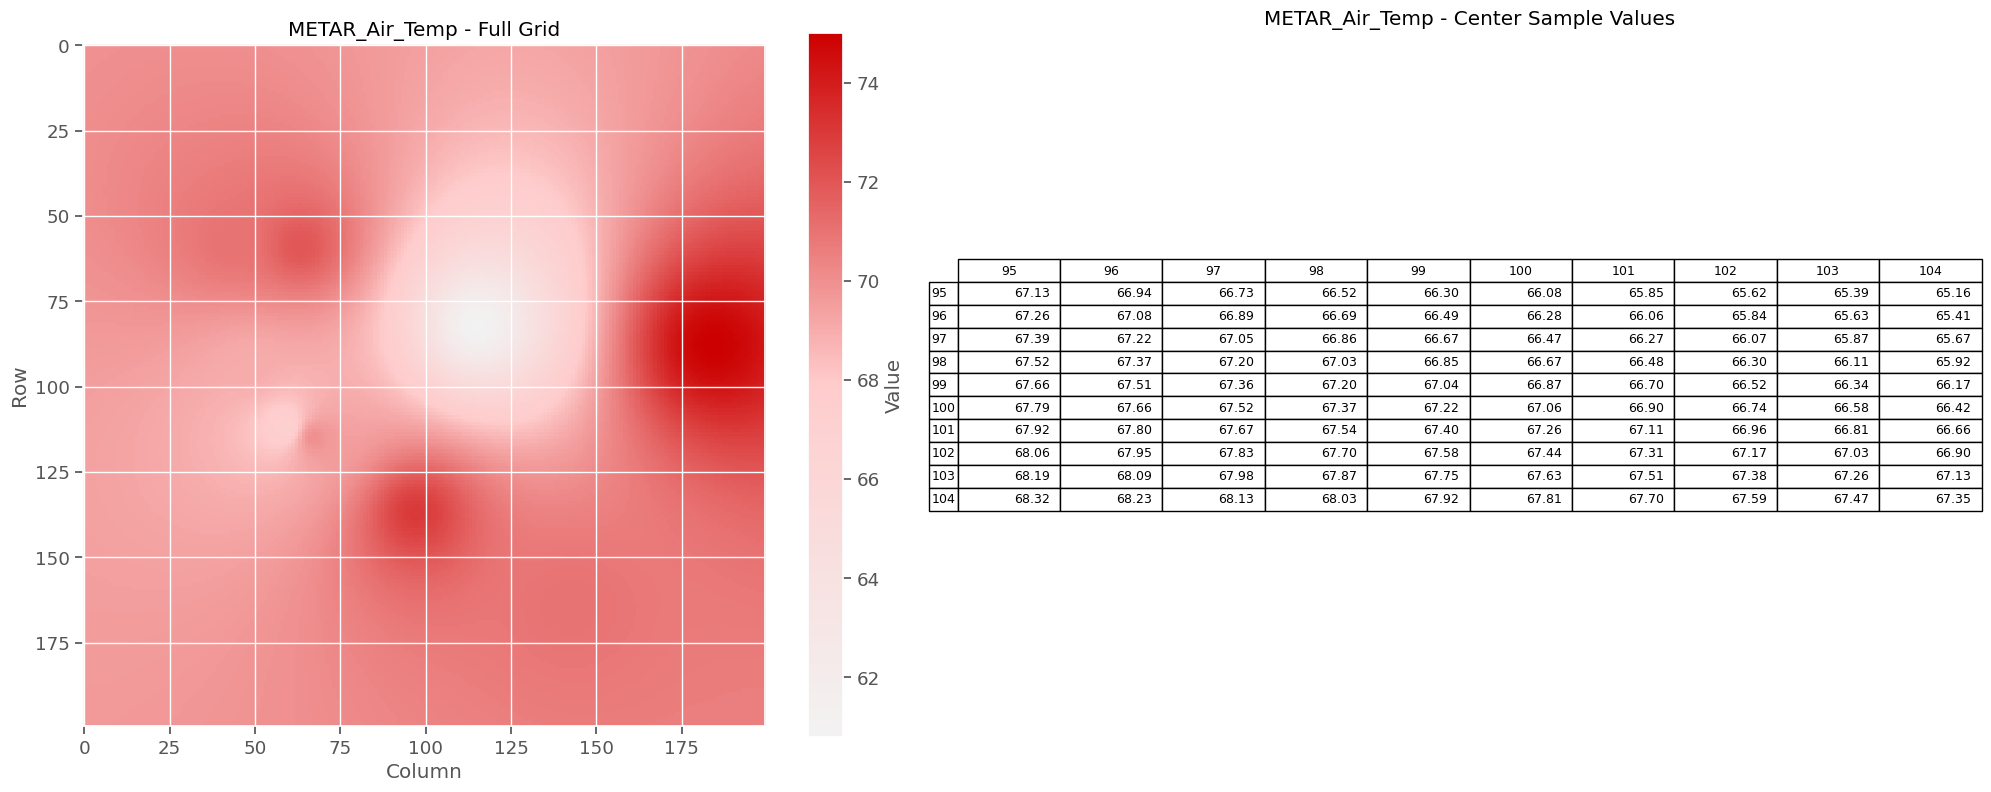


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,67.127922,66.935561,66.733463,66.522523,66.303898,66.079033,65.849661,65.617800,65.385739,65.156001
96,67.258424,67.078159,66.888790,66.691159,66.486350,66.275707,66.060834,65.843596,65.626100,65.410662
97,67.390723,67.222469,67.045722,66.861270,66.670124,66.473527,66.272959,66.070134,65.866981,65.665622
98,67.524079,67.367673,67.203355,67.031860,66.854123,66.671289,66.484718,66.295976,66.106827,65.919202
99,67.657870,67.513085,67.360935,67.202099,67.037436,66.867998,66.695024,66.519945,66.344361,66.170030
100,67.791593,67.658155,67.517859,67.371325,67.219341,67.062863,66.903020,66.741108,66.578581,66.417028
101,67.924865,67.802467,67.673671,67.539043,67.399296,67.255296,67.108065,66.958776,66.808740,66.659394
102,68.057425,67.945736,67.828064,67.704916,67.576933,67.444896,67.309724,67.172475,67.034329,66.896582
103,68.189127,68.087805,67.980865,67.868754,67.752045,67.631435,67.507749,67.381933,67.255051,67.128267



### Channel 14: METAR_Air_Pressure ###
Min: 1015.6000
Max: 1016.2000
Mean: 1015.8624
Std: 0.1331
Data coverage: 100.00% (40000/40000 non-zero pixels)


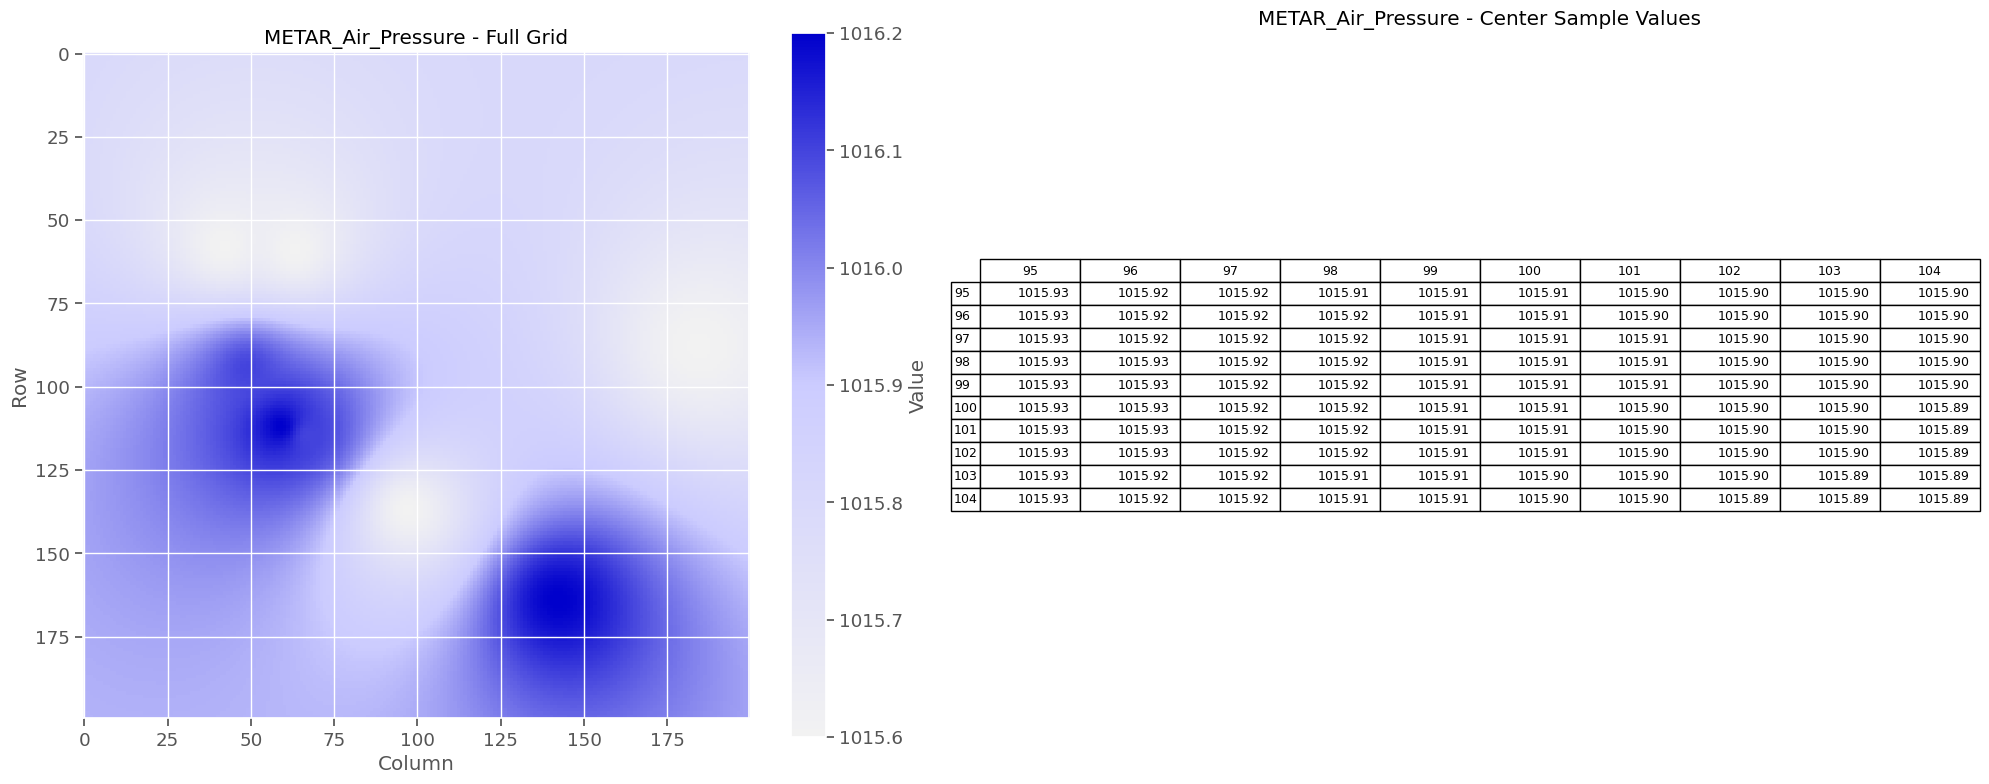


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,1015.925286,1015.921463,1015.917753,1015.914162,1015.910692,1015.907343,1015.904117,1015.901015,1015.898034,1015.895174
96,1015.927032,1015.923004,1015.919103,1015.915333,1015.911698,1015.908198,1015.904836,1015.901610,1015.898519,1015.895563
97,1015.928470,1015.924239,1015.920148,1015.916204,1015.912408,1015.908763,1015.905269,1015.901926,1015.898734,1015.895689
98,1015.929580,1015.925148,1015.920872,1015.916757,1015.912805,1015.909019,1015.905400,1015.901948,1015.898661,1015.895535
99,1015.930344,1015.925714,1015.921254,1015.916972,1015.912869,1015.908949,1015.905212,1015.901657,1015.898283,1015.895087
100,1015.930742,1015.925914,1015.921274,1015.916829,1015.912580,1015.908532,1015.904684,1015.901035,1015.897584,1015.894326
101,1015.930750,1015.925727,1015.920910,1015.916306,1015.911917,1015.907747,1015.903796,1015.900062,1015.896544,1015.893235
102,1015.930346,1015.925130,1015.920139,1015.915380,1015.910857,1015.906573,1015.902528,1015.898719,1015.895144,1015.891797
103,1015.929504,1015.924096,1015.918934,1015.914026,1015.909377,1015.904987,1015.900856,1015.896983,1015.893363,1015.889991



### Channel 15: METAR_Dew_Point ###
Min: 14.0000
Max: 39.0000
Mean: 29.5578
Std: 3.6706
Data coverage: 100.00% (40000/40000 non-zero pixels)


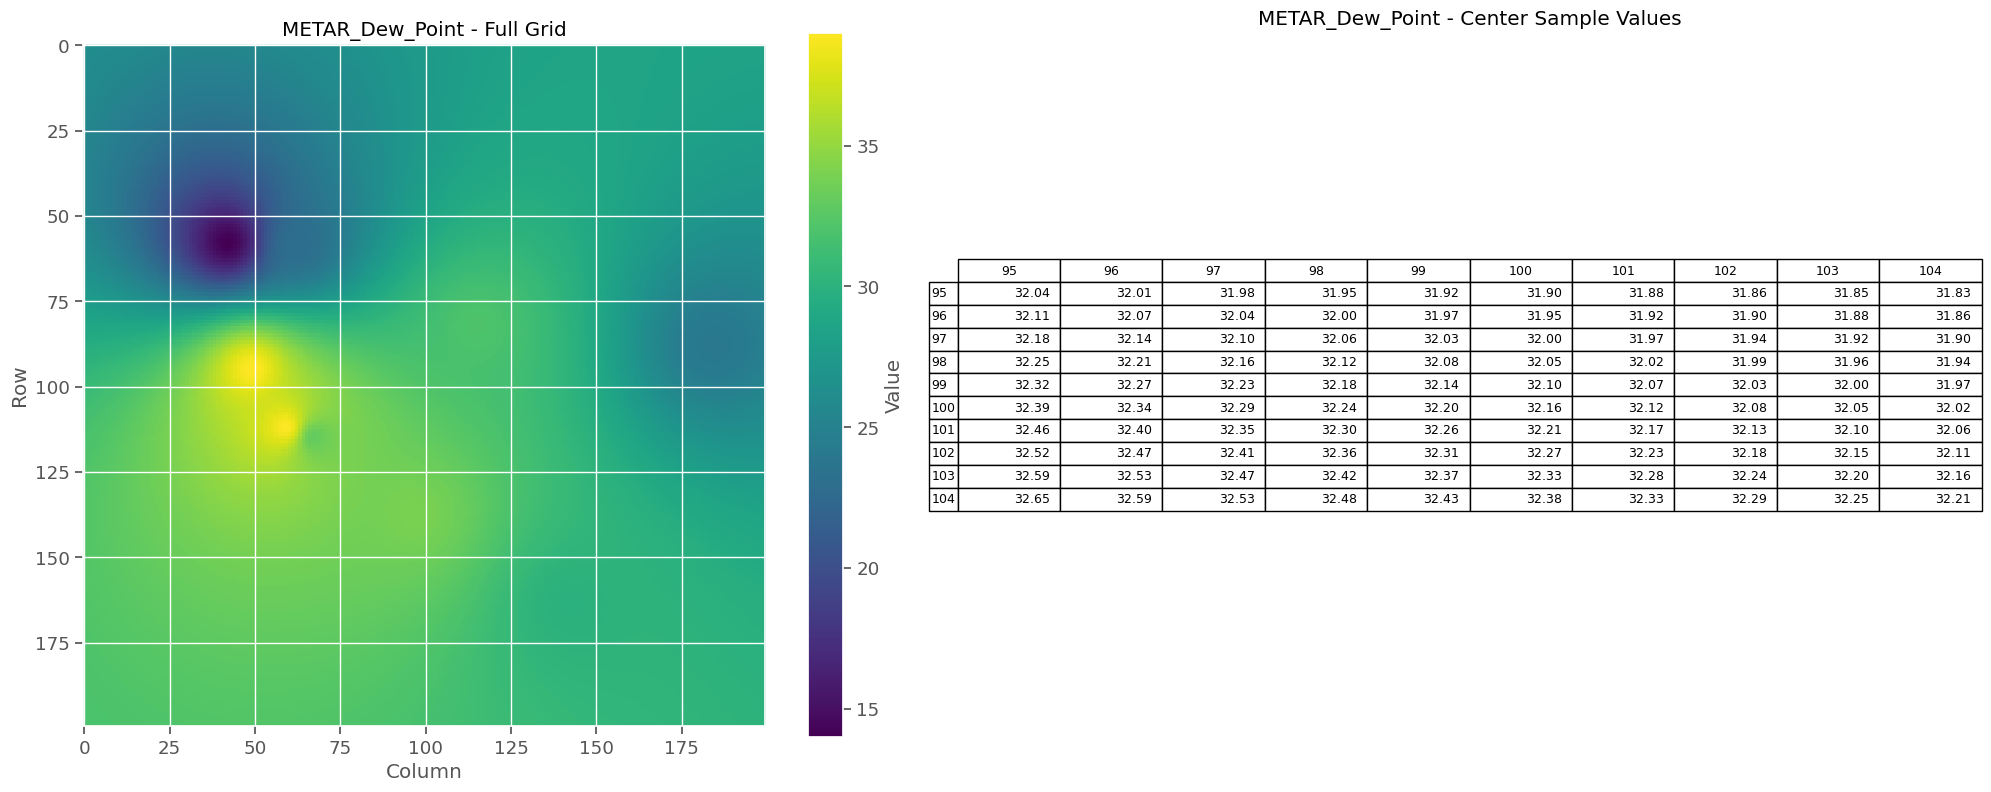


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,32.042616,32.007266,31.975161,31.946227,31.920376,31.897502,31.877482,31.860166,31.845374,31.832893
96,32.113639,32.073975,32.037509,32.004167,31.973865,31.946503,31.921966,31.900117,31.880792,31.863800
97,32.184195,32.140696,32.100334,32.063034,32.028714,31.997280,31.968622,31.942613,31.919105,31.897924
98,32.254059,32.207202,32.163407,32.122600,32.084697,32.049608,32.017228,31.987439,31.960104,31.935066
99,32.322997,32.273252,32.226483,32.182612,32.141558,32.103230,32.067527,32.034339,32.003538,31.974979
100,32.390775,32.338603,32.289308,32.242811,32.199029,32.157872,32.119242,32.083031,32.049121,32.017379
101,32.457170,32.403020,32.351636,32.302939,32.256843,32.213258,32.172086,32.133224,32.096559,32.061967
102,32.521980,32.466283,32.413235,32.362752,32.314744,32.269120,32.225782,32.184630,32.145555,32.108441
103,32.585026,32.528202,32.473898,32.422026,32.372495,32.325209,32.280069,32.236977,32.195826,32.156508


In [9]:
# Get indices for METAR channels
metar_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['metar_channels']]

# Analyze each METAR channel
for i, idx in enumerate(metar_indices):
    channel_name = channel_info['channel_names'][idx]
    
    # Use appropriate colormap based on channel content
    if any(term in channel_name.lower() for term in ['temp', 'heat']):
        cmap = cmap_red
    elif any(term in channel_name.lower() for term in ['precip', 'rain', 'humidity', 'dewpoint']):
        cmap = cmap_green
    elif any(term in channel_name.lower() for term in ['wind', 'pressure', 'visibility']):
        cmap = cmap_blue
    else:
        cmap = 'viridis'
        
    df = analyze_channel(data, idx, channel_name, colormap=cmap)
    display(df)

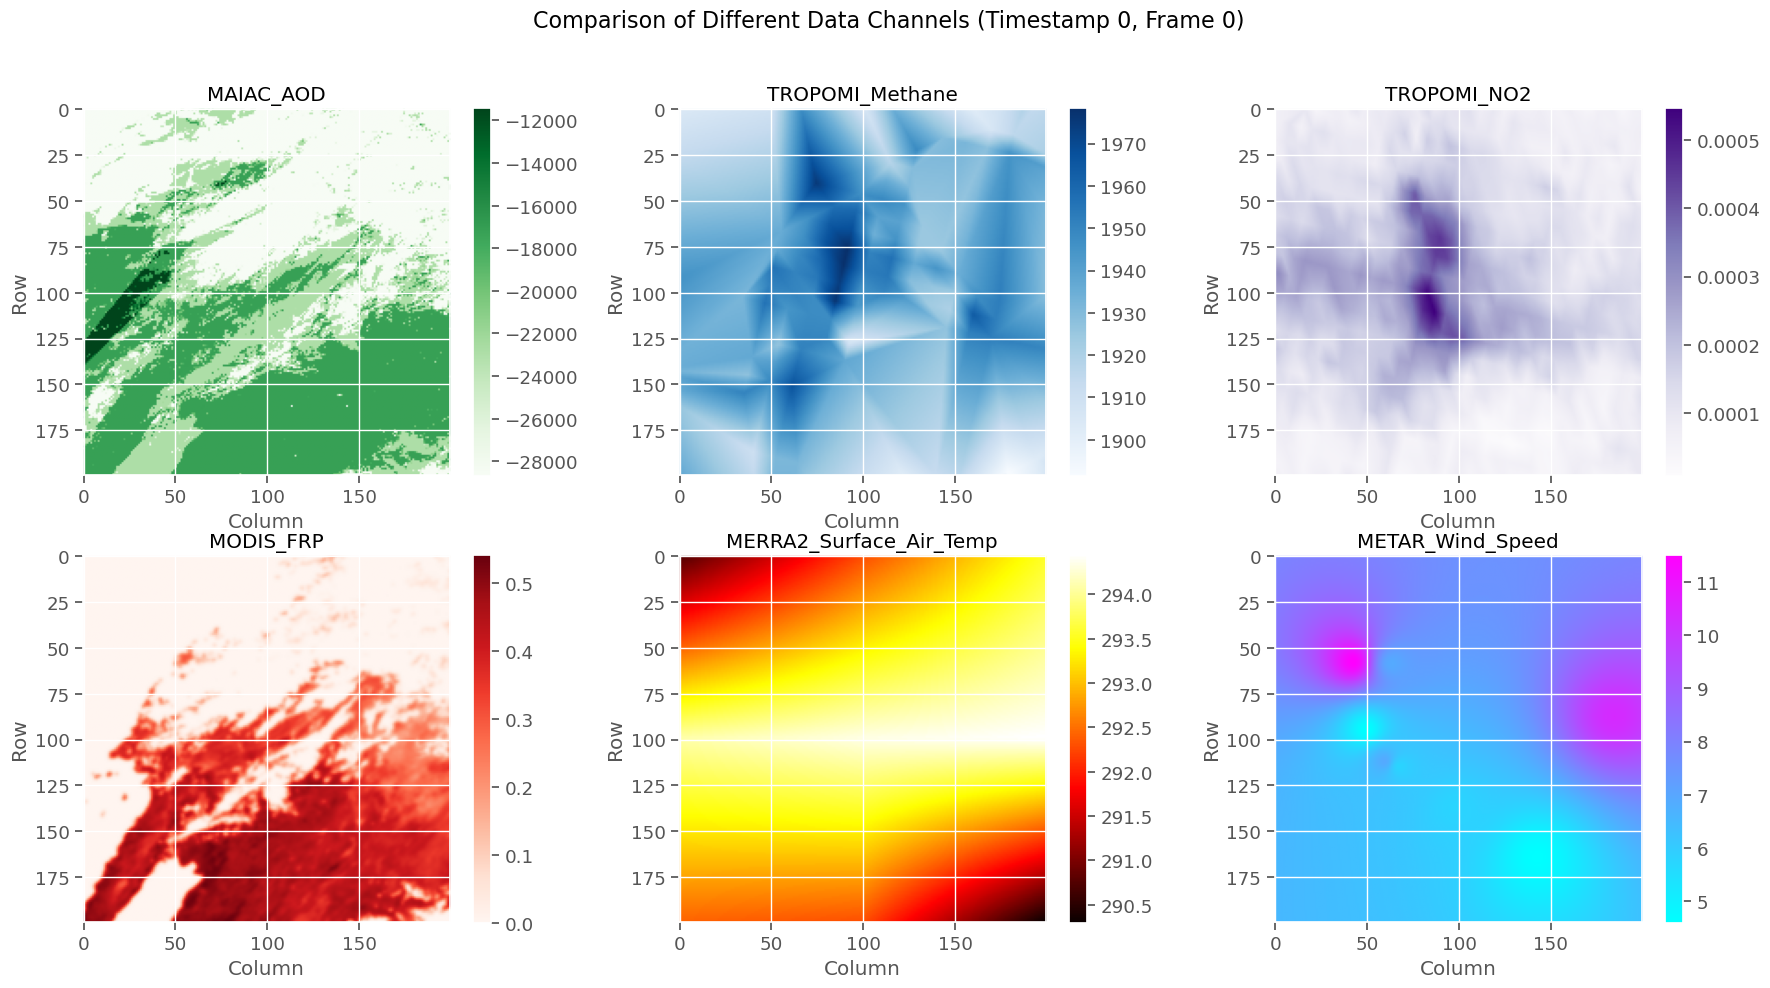

In [10]:
# Compare different data channels at the same timestamp/frame
timestamp_idx = 0
frame_idx = 0

# Get channel information
channel_info = data.get_channel_info()

# Select diverse channels to compare
channels_to_compare = [
    ('MAIAC_AOD', 0),                # Aerosol optical depth
    ('TROPOMI_Methane', 1),          # Methane concentration
    ('TROPOMI_NO2', 2),              # Nitrogen dioxide
    ('MODIS_FRP', 3),                # Fire radiative power
    ('MERRA2_Surface_Air_Temp', 5),  # Temperature
    ('METAR_Wind_Speed', 7)          # Wind speed
]

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Select appropriate colormaps for different variables
cmaps = {
    'MAIAC_AOD': 'Greens',
    'TROPOMI_Methane': 'Blues', 
    'TROPOMI_NO2': 'Purples',
    'MODIS_FRP': 'Reds',
    'MERRA2_Surface_Air_Temp': 'hot',
    'METAR_Wind_Speed': 'cool'
}

# Plot each channel
for i, (channel_name, channel_offset) in enumerate(channels_to_compare):
    if i < len(axes):
        # Find the actual channel index
        channel_idx = channel_offset  # Default to offset
        for j, name in enumerate(channel_info['channel_names']):
            if name == channel_name:
                channel_idx = j
                break
        
        # Get data for this channel
        channel_data = data.data[timestamp_idx, frame_idx, :, :, channel_idx]
        
        # Display the data
        im = axes[i].imshow(channel_data, cmap=cmaps.get(channel_name, 'viridis'))
        axes[i].set_title(f"{channel_name}")
        axes[i].set_xlabel('Column')
        axes[i].set_ylabel('Row')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i])

plt.suptitle(f"Comparison of Different Data Channels (Timestamp {timestamp_idx}, Frame {frame_idx})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()